# Model TCNN Time Series for COVID : Training

This notebook explore from official "Sante Publique France" data about COVID-19 in France


These data have 4-days time delay.

The time series model is created and trained to predict future 7 next days (output) based on 14 past last days (input).


**Input Features are daily data of:**

- Min/Max Temperatures
- Min/Max Humidities
- nb. Confirmed cases
- nb. Tested cases
- Day of the week
- Mean Age of Tested cases
- Mean Age of Confirmed cases

**DATA sources:**

Tested / Confirmed cases: https://www.data.gouv.fr/fr/datasets/donnees-relatives-aux-resultats-des-tests-virologiques-covid-19

Météo France : https://public.opendatasoft.com/explore/dataset/donnees-synop-essentielles-omm

**GitHub:** https://github.com/jeugregg/coronavirusModel

## Settings notebook

In [1]:
mode_collect = False # True : retrieve data online (set TRAIN_SPLIT in model_kr)
mode_train = True # True : Train model

## import

In [2]:
%matplotlib inline

# figure lib
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import seaborn as sns
sns.set(color_codes=True, font_scale=1.33)
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

# data useful lib
import pandas as pd
import numpy as np

# helper lib
import shutil
import os, stat
import re
import datetime
import math

# read json from http
import json
import urllib.request

# read csv from http
import io
import requests

# model lib
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras import Input, Model
from tcn import TCN, tcn_full_summary

from sklearn.metrics import mean_absolute_error

# projects libs
from my_helpers.data_plots import get_data_pos
from my_helpers.data_plots import load_data_pos
from my_helpers.data_plots import get_old_data_pos
from my_helpers.data_plots import load_old_data_pos
from my_helpers.data_plots import PATH_DF_GOUV_FR_OLD
from my_helpers.model import multivariate_data
from my_helpers.model import prepare_to_lambda
from my_helpers.model import retrieve_from_lambda
from my_helpers.model import create_list_past_hist
from my_helpers.model import predict_list

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [5]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [6]:
tf.test.is_built_with_cuda()

True

In [7]:
tf.test.is_built_with_gpu_support()

True

In [8]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 10608733365639511175,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 7017170208
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 9406707547344484936
 physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1080, pci bus id: 0000:00:03.0, compute capability: 6.1"]

## Definitions

In [9]:
PATH_TO_SAVE_DATA = "."
PATH_DF_POS_FR = PATH_TO_SAVE_DATA + '/' + 'df_pos_fr.csv'
PATH_DF_TEST_FR = PATH_TO_SAVE_DATA + '/' + 'df_test_fr.csv'
PATH_JSON_METEO_FR = PATH_TO_SAVE_DATA + '/' + 'data_meteo_fr.json'
PATH_DF_FEAT_FR = PATH_TO_SAVE_DATA + '/' + 'df_feat_fr.csv' 
PATH_GEO_DEP_FR = PATH_TO_SAVE_DATA + '/sources/geofrance/' + 'departments.csv'
PATH_MDL_MULTI_STEP = PATH_TO_SAVE_DATA + '/' + "mdl_multi_step_pos_fr_tcn"
PATH_MDL_MULTI_TFLITE = PATH_TO_SAVE_DATA + '/' + \
    'serverless/tensorflow_lite_on_aws_lambda'
PATH_MDL_MULTI_TFLITE_FILE = PATH_MDL_MULTI_TFLITE + '/' + \
    "converted_model.tflite"
PATH_SERVERLESS = PATH_MDL_MULTI_TFLITE + '/' + 'serverless.yml'

date_format = "%Y-%m-%d"

#NB_POS_DATE_MIN_DF_FEAT = 140734 # on 13/05/2020
NB_POS_DATE_MIN_DF_FEAT = 140227 # on 12/05/2020

URL_PREDICT = 'https://yl0910jrga.execute-api.us-east-2.amazonaws.com/dev/infer'

# model 
PAST_HISTORY = 14 # days used to predict next values in future
FUTURE_TARGET = 7 # nb predict days later
STEP = 1

# plot
nb_period_plot = 15
NB_DAY_PLOT = FUTURE_TARGET*nb_period_plot
list_feat = ['T_min', 'T_max', 'H_min', 'H_max', 'pos', 'test', 'day_num',
                                           'age_pos', 'age_test']

##  Helper functions

In [10]:
# FOR DATES
def add_days(str_date_0, nb_days_CV):
    '''
    add days to string dates
    '''
    date_format = "%Y-%m-%d"
    date_last = datetime.datetime.strptime(str_date_0, date_format)
    date_start = date_last + datetime.timedelta(days=nb_days_CV)
    str_date_start = date_start.strftime(date_format)
    return str_date_start

def generate_list_dates(str_date_0, str_date_1, step=1, date_format=None):
    if date_format is None:
        date_format = "%Y-%m-%d"
    date_0 = datetime.datetime.strptime(str_date_0, date_format)
    date_1 = datetime.datetime.strptime(str_date_1, date_format)
    delta = date_1 - date_0
    if delta.days > 0:
        return [(date_0 + \
                 datetime.timedelta(days=I)).strftime(date_format) \
               for I in range(1, delta.days+1, step)]
    else:
        return None


# For Training plots
def create_time_steps(length):
    '''
    create time steps
    '''
    return list(range(-length, 0))

def plot_train_history(history, title):
    """
    Plot train errors
    """
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()

    plt.show()
    
# save file before update
def clean_file(path_file_name):
    '''
    Clean file already traited : rename file with date
    '''
    try:
        d = datetime.datetime.now()
        str_date = '_' + d.strftime("%Y%m%d_%H_%M_%S")
       
        res_re = re.search('\.\w+$', path_file_name)
        
        path_file_name_saved = \
            path_file_name[0:res_re.start()] + str_date + res_re.group(0)
         
        shutil.move(path_file_name, path_file_name_saved) 
        print('File {} moved!'.format(path_file_name_saved))
    except:
        print('File {} does not exist!'.format(path_file_name))

## Retrieve data

In [11]:
if mode_collect:
    get_data_pos()
df_feat_fr = load_data_pos()

## Retrieve old data

In [12]:
if not os.path.isfile(PATH_DF_GOUV_FR_OLD):
    get_old_data_pos()
    
df_feat_fr_old = load_old_data_pos()

df_feat_fr_old

date       T_min       T_max      H_min      H_max  pos  \
date                                                                        
2020-03-10  2020-03-10  283.708333  289.736667  70.666667  90.416667    8   
2020-03-11  2020-03-11  285.335000  291.913333  66.183333  91.383333   16   
2020-03-12  2020-03-12  284.048333  290.268333  63.866667  89.883333   33   
2020-03-13  2020-03-13  282.503333  289.148333  56.150000  88.500000   61   
2020-03-14  2020-03-14  282.253333  289.338333  62.116667  88.683333   54   
...                ...         ...         ...        ...        ...  ...   
2020-05-08  2020-05-08  287.051695  296.029661  53.568966  86.327586   15   
2020-05-09  2020-05-09  288.019492  295.305932  60.448276  87.448276   29   
2020-05-10  2020-05-10  288.058621  293.532759  68.228070  92.649123   17   
2020-05-11  2020-05-11  284.517797  290.512712  67.310345  90.396552  210   
2020-05-12  2020-05-12  283.870000  289.811667  61.932203  86.322034  168   

              age_pos   test   age_test  day_num  nb_cases  
date                                                        
2020-03-10  66.625000     79  50.696203        2    101343  
2020-03-11  44.875000    108  45.587963        3    101359  
2020-03-12  58.681818    156  49.362179        4    101392  
2020-03-13  49.073770    350  44.335714        5    101453  
2020-03-14  51.222222    167  48.664671        6    101507  
...               ...    ...        ...      ...       ...  
2020-05-08  65.366667    448  59.638393        5    139803  
2020-05-09  45.431034   1513  52.868804        6    139832  
2020-05-10  61.676471    293  60.738908        0    139849  
2020-05-11  63.357143  10339  53.020892        1    140059  
2020-05-12  63.345238  10567  51.926706        2    140227  

[64 rows x 11 columns]

## Train/Test split

In [13]:
df_feat_fr = pd.read_csv(PATH_DF_FEAT_FR)
df_feat_fr.index = df_feat_fr["date"]

df_feat_fr

T_min        date       T_max      H_min      H_max  extrap  \
date                                                                           
2020-05-13  284.926667  2020-05-13  290.505000  64.661017  88.135593     0.0   
2020-05-14  285.050000  2020-05-14  290.963333  59.406780  84.847458     0.0   
2020-05-15  285.308333  2020-05-15  291.920000  57.372881  82.966102     0.0   
2020-05-16  284.956667  2020-05-16  293.500000  53.741379  86.534483     0.0   
2020-05-17  285.598333  2020-05-17  294.446667  49.879310  85.500000     0.0   
...                ...         ...         ...        ...        ...     ...   
2021-06-14  289.731667  2021-06-14  299.831667  49.766667  83.683333     0.0   
2021-06-15  290.350000  2021-06-15  299.773333  51.966667  84.866667     0.0   
2021-06-16  290.698333  2021-06-16  300.330000  54.766667  87.483333     0.0   
2021-06-17  291.226667  2021-06-17  297.420000  64.366667  89.683333     0.0   
2021-06-18  290.821667  2021-06-18  298.035000  60.700000  88.983333     0.0   

             pos    age_pos    test   age_test  day_num  nb_cases  sum_cases  \
date                                                                           
2020-05-13   881  61.104427   39013  55.451567        3    141108        NaN   
2020-05-14   981  60.403670   41975  54.832186        4    142089        NaN   
2020-05-15  1019  60.063788   47596  54.404446        5    143108        NaN   
2020-05-16   291  60.020619   16523  54.480058        6    143399        NaN   
2020-05-17   141  61.248227    6611  58.226895        0    143540        NaN   
...          ...        ...     ...        ...      ...       ...        ...   
2021-06-14  3920  39.861990  337285  43.112054        1   5680443    64639.0   
2021-06-15  2813  39.135087  280727  40.932269        2   5683256    59526.0   
2021-06-16  2492  39.583467  247709  44.233136        3   5685748    54461.0   
2021-06-17  2455  39.395519  314162  39.614202        4   5688203    49936.0   
2021-06-18  2484  39.342995  378648  41.117230        5   5690687    45830.0   

                  Rt  rate_pos  
date                            
2020-05-13       NaN  2.258222  
2020-05-14       NaN  2.337105  
2020-05-15       NaN  2.140936  
2020-05-16       NaN  1.761181  
2020-05-17       NaN  2.132809  
...              ...       ...  
2021-06-14  0.473144  1.162222  
2021-06-15  0.461099  1.002041  
2021-06-16  0.442675  1.006019  
2021-06-17  0.425060  0.781444  
2021-06-18  0.410678  0.656018  

[402 rows x 15 columns]

In [14]:
if mode_collect:
    # keep 25 Validation samples:
    #TRAIN_SPLIT = df_feat_fr.shape[0] - (2 * FUTURE_TARGET)
    TRAIN_SPLIT = df_feat_fr.shape[0] - (2 * FUTURE_TARGET)
    TRAIN_SPLIT = round(0.8*df_feat_fr.shape[0])
else:
    from my_helpers.model import TRAIN_SPLIT
print(f"TRAIN_SPLIT = {TRAIN_SPLIT}")

TRAIN_SPLIT = 318


In [15]:
df_feat_fr["train"] = [True if I <= TRAIN_SPLIT else False \
                       for I in range(df_feat_fr.shape[0])]
df_feat_fr

T_min        date       T_max      H_min      H_max  extrap  \
date                                                                           
2020-05-13  284.926667  2020-05-13  290.505000  64.661017  88.135593     0.0   
2020-05-14  285.050000  2020-05-14  290.963333  59.406780  84.847458     0.0   
2020-05-15  285.308333  2020-05-15  291.920000  57.372881  82.966102     0.0   
2020-05-16  284.956667  2020-05-16  293.500000  53.741379  86.534483     0.0   
2020-05-17  285.598333  2020-05-17  294.446667  49.879310  85.500000     0.0   
...                ...         ...         ...        ...        ...     ...   
2021-06-14  289.731667  2021-06-14  299.831667  49.766667  83.683333     0.0   
2021-06-15  290.350000  2021-06-15  299.773333  51.966667  84.866667     0.0   
2021-06-16  290.698333  2021-06-16  300.330000  54.766667  87.483333     0.0   
2021-06-17  291.226667  2021-06-17  297.420000  64.366667  89.683333     0.0   
2021-06-18  290.821667  2021-06-18  298.035000  60.700000  88.983333     0.0   

             pos    age_pos    test   age_test  day_num  nb_cases  sum_cases  \
date                                                                           
2020-05-13   881  61.104427   39013  55.451567        3    141108        NaN   
2020-05-14   981  60.403670   41975  54.832186        4    142089        NaN   
2020-05-15  1019  60.063788   47596  54.404446        5    143108        NaN   
2020-05-16   291  60.020619   16523  54.480058        6    143399        NaN   
2020-05-17   141  61.248227    6611  58.226895        0    143540        NaN   
...          ...        ...     ...        ...      ...       ...        ...   
2021-06-14  3920  39.861990  337285  43.112054        1   5680443    64639.0   
2021-06-15  2813  39.135087  280727  40.932269        2   5683256    59526.0   
2021-06-16  2492  39.583467  247709  44.233136        3   5685748    54461.0   
2021-06-17  2455  39.395519  314162  39.614202        4   5688203    49936.0   
2021-06-18  2484  39.342995  378648  41.117230        5   5690687    45830.0   

                  Rt  rate_pos  train  
date                                   
2020-05-13       NaN  2.258222   True  
2020-05-14       NaN  2.337105   True  
2020-05-15       NaN  2.140936   True  
2020-05-16       NaN  1.761181   True  
2020-05-17       NaN  2.132809   True  
...              ...       ...    ...  
2021-06-14  0.473144  1.162222  False  
2021-06-15  0.461099  1.002041  False  
2021-06-16  0.442675  1.006019  False  
2021-06-17  0.425060  0.781444  False  
2021-06-18  0.410678  0.656018  False  

[402 rows x 16 columns]

## Exploration

Distribution of TRAIN / VALIDATION dataset :

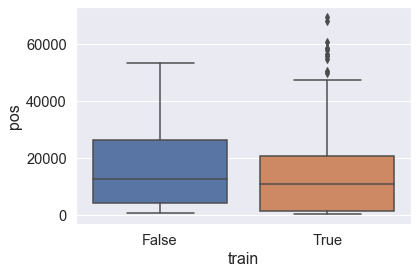

In [16]:
ax = sns.boxplot(x="train", y="pos", data=df_feat_fr)

### age

#### First wave

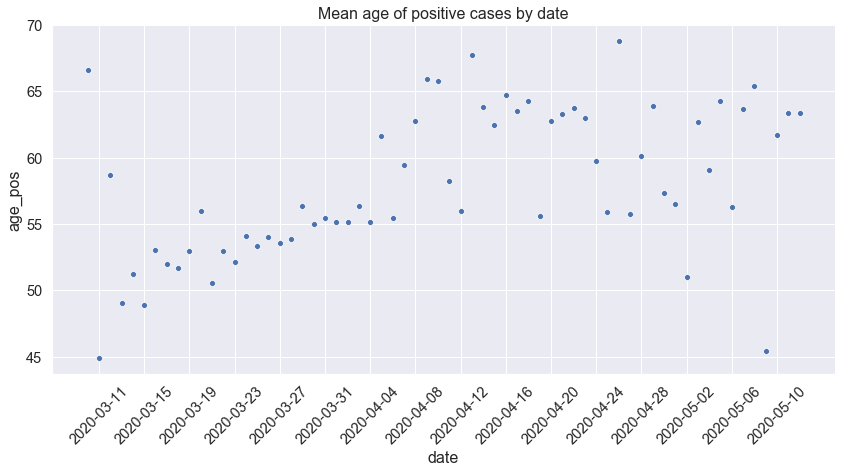

In [17]:
sns.relplot(x="date", y="age_pos", data=df_feat_fr_old, height=6, aspect=2);
plt.xticks(generate_list_dates(df_feat_fr_old["date"].min(), 
                    df_feat_fr_old["date"].max(), 4))
plt.xticks(rotation=45);
plt.title("Mean age of positive cases by date");

#### Second wave

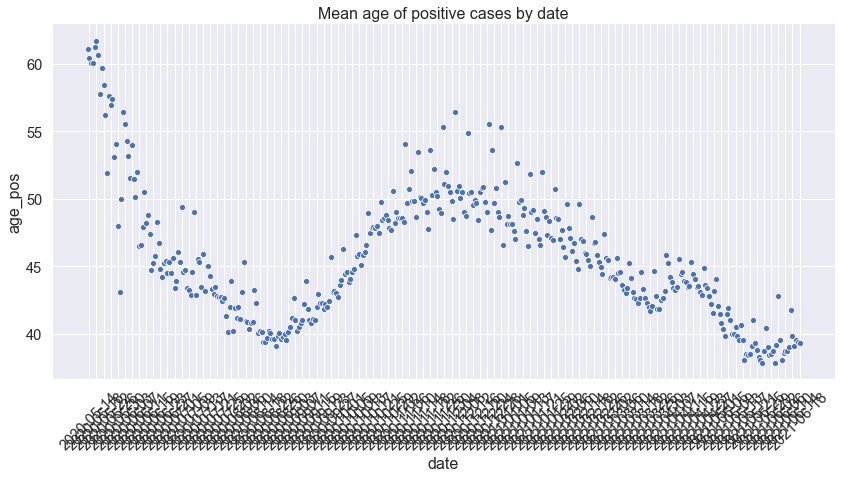

In [18]:
sns.relplot(x="date", y="age_pos", data=df_feat_fr, height=6, aspect=2);
plt.xticks(generate_list_dates(df_feat_fr["date"].min(), 
                    df_feat_fr["date"].max(), 4))
plt.xticks(rotation=45);
plt.title("Mean age of positive cases by date");

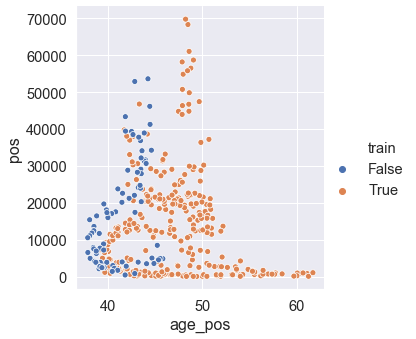

In [19]:
sns.relplot(x="age_pos", y="pos", hue="train", data=df_feat_fr);

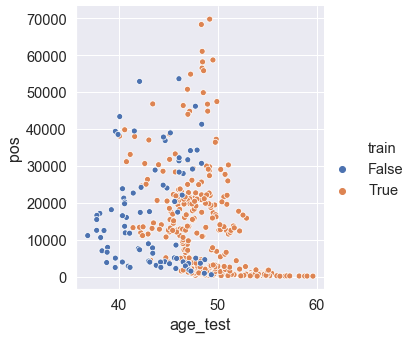

In [20]:
sns.relplot(x="age_test", y="pos", hue="train", data=df_feat_fr);

### Impact of day 

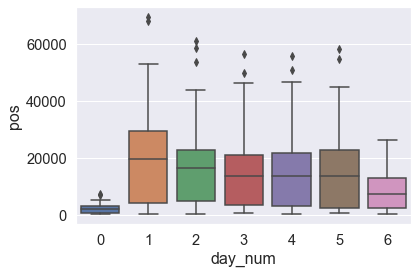

In [21]:
ax = sns.boxplot(x="day_num", y="pos", data=df_feat_fr)

=> It is not the reality. On weekend, a lot of local medical structures don't trace positive cases.

### Temperature impact

In [22]:
df_feat_fr["T_mean"] = 0.5 * (df_feat_fr["T_min"] + df_feat_fr["T_max"])

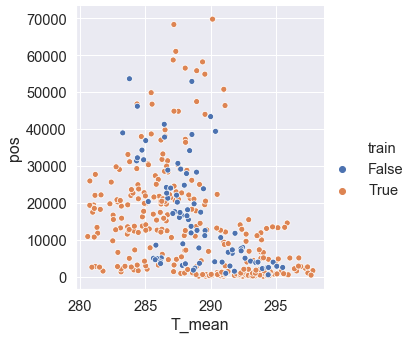

In [23]:
sns.relplot(x="T_mean", y="pos", hue="train", data=df_feat_fr);

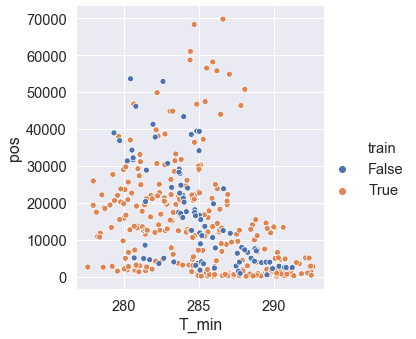

In [24]:
sns.relplot(x="T_min", y="pos", hue="train", data=df_feat_fr);

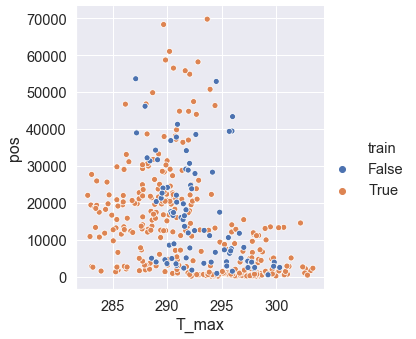

In [25]:
sns.relplot(x="T_max", y="pos", hue="train", data=df_feat_fr);

Impact of cold temperature :

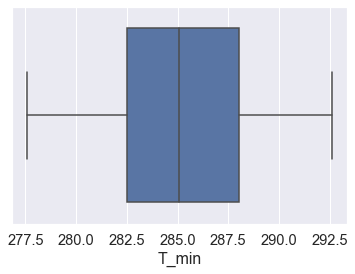

In [26]:
ax = sns.boxplot(x="T_min", data=df_feat_fr)

In [27]:
df_feat_fr["T_min"].mean()

285.24678986905883

In [28]:
(df_feat_fr["T_min"] < df_feat_fr["T_min"].mean()).value_counts()

True     210
False    192
Name: T_min, dtype: int64

In [29]:
(df_feat_fr["T_min"] < df_feat_fr["T_min"].median()).value_counts()

True     201
False    201
Name: T_min, dtype: int64

In [30]:
df_feat_fr["T_min"].median()

285.05083333333334

In [31]:
df_feat_fr["cold_min"] = df_feat_fr["T_min"] < df_feat_fr["T_min"].median()

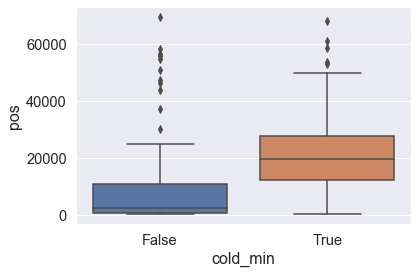

In [32]:
ax = sns.boxplot(x="cold_min", y="pos", data=df_feat_fr)

=> colder T min then more positive cases! but trend is not clear (more deviation with cold temperature)

Impact of T mean : 

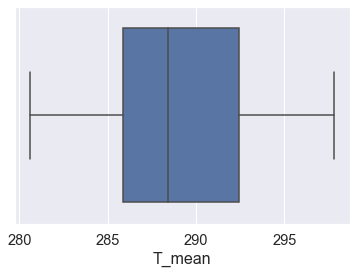

In [33]:
ax = sns.boxplot(x="T_mean", data=df_feat_fr)

In [34]:
df_feat_fr["T_mean"].median()

288.41375

In [35]:
df_feat_fr["cold_mean"] = df_feat_fr["T_mean"] < df_feat_fr["T_mean"].median()

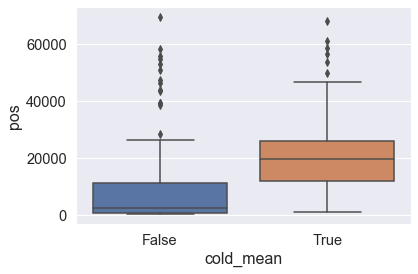

In [36]:
ax = sns.boxplot(x="cold_mean", y="pos", data=df_feat_fr)

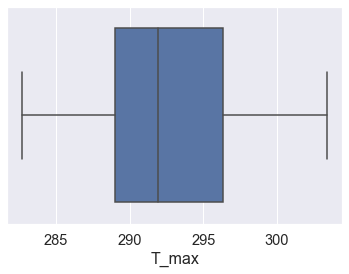

In [37]:
ax = sns.boxplot(x="T_max", data=df_feat_fr)

In [38]:
df_feat_fr["T_max"].median()

291.89583333333337

In [39]:
df_feat_fr["cold_max"] = df_feat_fr["T_max"] < df_feat_fr["T_max"].median()

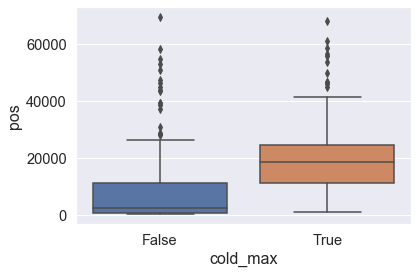

In [40]:
ax = sns.boxplot(x="cold_max", y="pos", data=df_feat_fr)

=> like T min

### Impact of Humidity

In [41]:
df_feat_fr["H_mean"] = 0.5 * (df_feat_fr["H_min"] + df_feat_fr["H_max"])

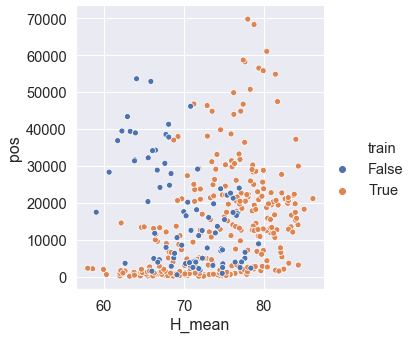

In [42]:
sns.relplot(x="H_mean", y="pos", hue="train", data=df_feat_fr);

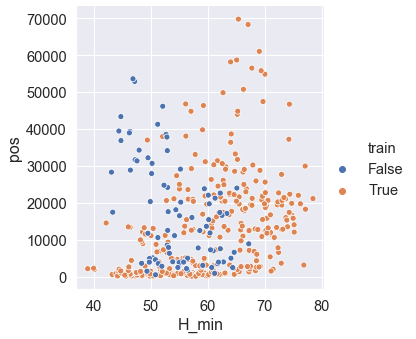

In [43]:
sns.relplot(x="H_min", y="pos", hue="train", data=df_feat_fr);

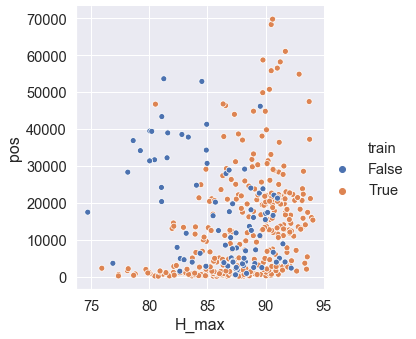

In [44]:
sns.relplot(x="H_max", y="pos", hue="train", data=df_feat_fr);

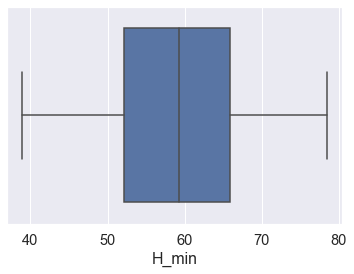

In [45]:
ax = sns.boxplot(x="H_min", data=df_feat_fr)

In [46]:
df_feat_fr["H_min"].median()

59.32097701149425

In [47]:
df_feat_fr["dry_min"] = df_feat_fr["H_min"] < df_feat_fr["H_min"].median()

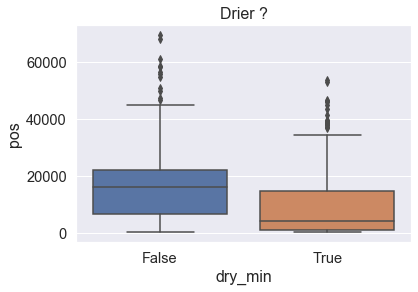

In [60]:
ax = sns.boxplot(x="dry_min", y="pos", data=df_feat_fr)
ax.set_title("Drier ?");

=> DRIER, less positive cases

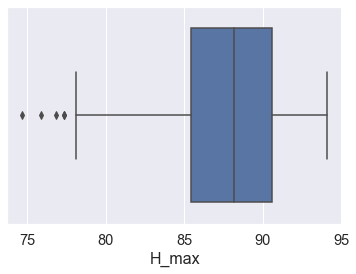

In [49]:
ax = sns.boxplot(x="H_max", data=df_feat_fr)

In [50]:
df_feat_fr["H_max"].median()

88.17627118644069

In [51]:
df_feat_fr["dry_max"] = df_feat_fr["H_max"] < df_feat_fr["H_max"].median()

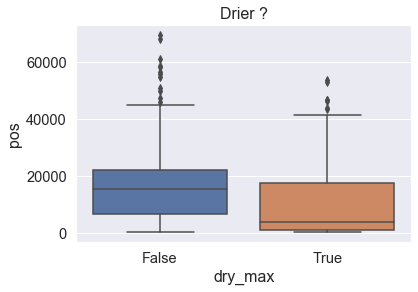

In [61]:
ax = sns.boxplot(x="dry_max", y="pos", data=df_feat_fr)
ax.set_title("Drier ?");

=> => Same than H min

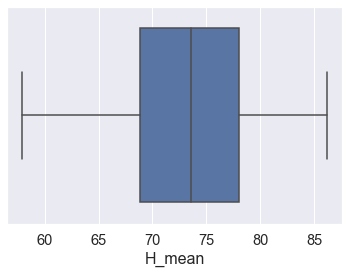

In [63]:
ax = sns.boxplot(x="H_mean", data=df_feat_fr)

In [64]:
df_feat_fr["H_mean"].median()

73.5969827586207

In [65]:
df_feat_fr["dry_mean"] = df_feat_fr["H_mean"] < df_feat_fr["H_mean"].median()

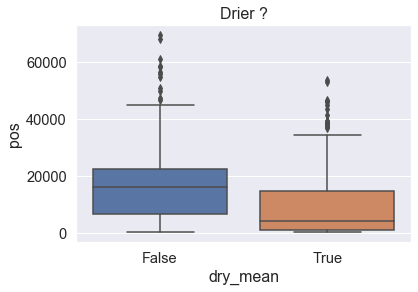

In [66]:
ax = sns.boxplot(x="dry_mean", y="pos", data=df_feat_fr)
ax.set_title("Drier ?");

=> Same H min

### Seasonality impact

In [67]:
df_feat_fr["month"] = df_feat_fr["date"].astype(np.datetime64).dt.month

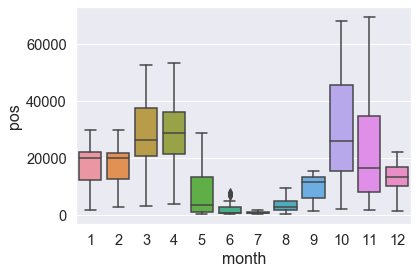

In [68]:
ax = sns.boxplot(x="month", y="pos", data=df_feat_fr)

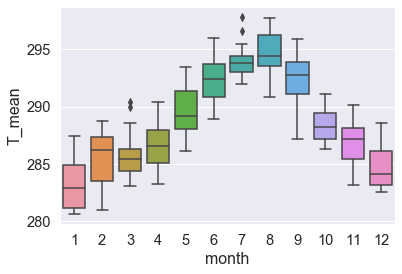

In [69]:
ax = sns.boxplot(x="month", y="T_mean", data=df_feat_fr)

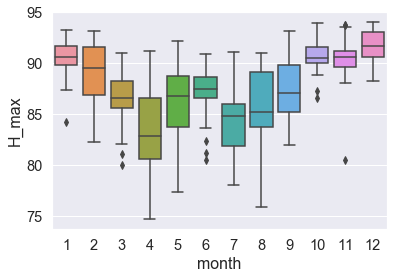

In [70]:
ax = sns.boxplot(x="month", y="H_max", data=df_feat_fr)

In [71]:
pt_month = df_feat_fr.pivot_table(values=["pos"],
                           index="month", aggfunc=np.sum)
pt_month

pos
month        
1      526559
2      495384
3      831057
4      815262
5      372405
6       89685
7       24747
8      105753
9      293132
10     932530
11     671029
12     392917

### Nb Tested

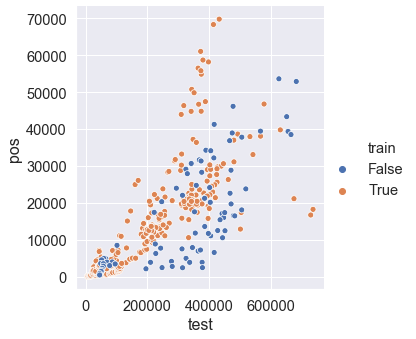

In [72]:
sns.relplot(x="test", y="pos", hue="train", data=df_feat_fr);

In [73]:
fig = go.Figure()
# Create and style traces
fig.add_trace(go.Scatter(x=df_feat_fr_old["date"].astype(np.datetime64), 
                         y=df_feat_fr_old["test"],
                    mode='lines+markers',
                    line_shape='linear',
                    connectgaps=True, name="Nb. Tested - 1st wave"))
fig.add_trace(go.Scatter(x=df_feat_fr["date"].astype(np.datetime64), 
                         y=df_feat_fr["test"],
                    mode='lines+markers',
                    line_shape='linear',
                    connectgaps=True, name="Nb. Tested"))
# Edit the layout
fig.update_layout(title='COVID-19 Tested  (France)',
                   yaxis_title='nb Tested')
fig.update_layout(legend_orientation="h", legend=dict(x=0, y=1.1))
fig.show()

In [74]:
fig = go.Figure()
# Create and style traces
fig.add_trace(go.Scatter(x=df_feat_fr_old["date"].astype(np.datetime64), 
                         y=100*df_feat_fr_old["pos"] / df_feat_fr_old["test"],
                    mode='lines+markers',
                    line_shape='linear',
                    connectgaps=True, name="Positive Rate - 1st wave"))
fig.add_trace(go.Scatter(x=df_feat_fr["date"].astype(np.datetime64), 
                         y=100*df_feat_fr["pos"] / df_feat_fr["test"],
                    mode='lines+markers',
                    line_shape='linear',
                    connectgaps=True, name="Positive Rate"))
# Edit the layout
fig.update_layout(title='COVID-19 Positive rate  (France)',
                   yaxis_title='pos. rate [%]')
fig.update_layout(legend_orientation="h", legend=dict(x=0, y=1.1))
fig.show()

## Prepare features

In [75]:
df_feat_fr = pd.read_csv(PATH_DF_FEAT_FR)
df_feat_fr.index = df_feat_fr["date"]

In [76]:
features = df_feat_fr.copy().filter(items=['T_min', 'T_max', 'H_min',
                                           'H_max', 'pos', 'test', 'day_num',
                                          'age_pos', 'age_test'])
features

T_min       T_max      H_min      H_max   pos    test  \
date                                                                     
2020-05-13  284.926667  290.505000  64.661017  88.135593   881   39013   
2020-05-14  285.050000  290.963333  59.406780  84.847458   981   41975   
2020-05-15  285.308333  291.920000  57.372881  82.966102  1019   47596   
2020-05-16  284.956667  293.500000  53.741379  86.534483   291   16523   
2020-05-17  285.598333  294.446667  49.879310  85.500000   141    6611   
...                ...         ...        ...        ...   ...     ...   
2021-06-14  289.731667  299.831667  49.766667  83.683333  3920  337285   
2021-06-15  290.350000  299.773333  51.966667  84.866667  2813  280727   
2021-06-16  290.698333  300.330000  54.766667  87.483333  2492  247709   
2021-06-17  291.226667  297.420000  64.366667  89.683333  2455  314162   
2021-06-18  290.821667  298.035000  60.700000  88.983333  2484  378648   

            day_num    age_pos   age_test  
date                                       
2020-05-13        3  61.104427  55.451567  
2020-05-14        4  60.403670  54.832186  
2020-05-15        5  60.063788  54.404446  
2020-05-16        6  60.020619  54.480058  
2020-05-17        0  61.248227  58.226895  
...             ...        ...        ...  
2021-06-14        1  39.861990  43.112054  
2021-06-15        2  39.135087  40.932269  
2021-06-16        3  39.583467  44.233136  
2021-06-17        4  39.395519  39.614202  
2021-06-18        5  39.342995  41.117230  

[402 rows x 9 columns]

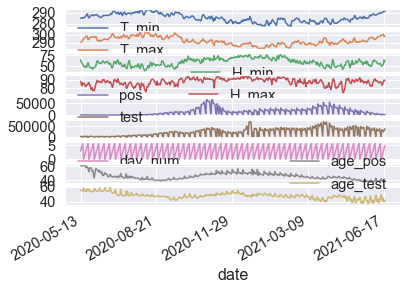

In [77]:
features.plot(subplots=True);

In [78]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)
dataset = (dataset-data_mean)/data_std

In [79]:
dataset.shape

(402, 9)

## Multi-step model

### Helper functions

In [111]:
def multi_step_plot(history, true_future, prediction):
    plt.figure(figsize=(12, 6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)

    plt.plot(num_in, np.array(history[:, 4]), label='History')
    plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
    if prediction.any():
        plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
    plt.legend(loc='upper left')
    plt.show()

def grads_by_days(x_train_multi, multi_step_model):
    '''
    Calculate gradients over Features and days before (mean over sequence) 
    : Nb Days before x Nb Features
    '''
    sum_grads = None
    for i_seq in range(x_train_multi.shape[0]):
        seq = tf.Variable(x_train_multi[i_seq][np.newaxis,:,:], 
                          dtype=tf.float32)

        with tf.GradientTape() as tape:
            predictions = multi_step_model(seq)

        grads = tape.gradient(predictions, seq)
        if sum_grads is None:
            sum_grads = grads.numpy()[0]
        else:
            sum_grads = +grads.numpy()[0]

    sum_grads = sum_grads / x_train_multi.shape[0]

    return sum_grads

def grads_by_features(x_train_multi, multi_step_model):
    '''
    Calculate gradients by feature : (Nb seq input x Nb Feature)
    '''
    arr_grads = None
    for i_seq in range(x_train_multi.shape[0]):
        seq = tf.Variable(x_train_multi[i_seq][np.newaxis,:,:], 
                          dtype=tf.float32)

        with tf.GradientTape() as tape:
            predictions = multi_step_model(seq)

        grads = tape.gradient(predictions, seq)
        grads = tf.reduce_mean(grads, axis=1).numpy()[0]

        if arr_grads is None:
            arr_grads = grads
        else:
            arr_grads = np.vstack((arr_grads, grads))
    return arr_grads


### data 14D_to_7D

In [81]:
TRAIN_SPLIT

318

In [82]:
dataset.shape

(402, 9)

In [83]:
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 4], 
                                0, TRAIN_SPLIT, PAST_HISTORY,
                                FUTURE_TARGET, STEP, single_step=False)

x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 4],
                                TRAIN_SPLIT-PAST_HISTORY, None, PAST_HISTORY,
                                FUTURE_TARGET, STEP, single_step=False)

In [84]:
y_train_multi.shape

(304, 7)

In [85]:
print ('{} Single window of past history : {}'.format(x_train_multi.shape[0],
                                                      x_train_multi[0].shape))
print ('\n {} Target future to predict : {}'.format(y_train_multi.shape[0],
                                                        y_train_multi[0].shape))

304 Single window of past history : (14, 9)

 304 Target future to predict : (7,)


In [86]:
BATCH_SIZE = x_train_multi.shape[0]
BATCH_SIZE_VAL = y_val_multi.shape[0]
BUFFER_SIZE = TRAIN_SPLIT
tf.random.set_seed(0)

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, 
                                                       y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE) \
    .batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE_VAL).repeat()

print("For Training : ")
print("BATCH_SIZE :", BATCH_SIZE)
print("BUFFER_SIZE :", BUFFER_SIZE)
print("\nFor validation : ")
print("BATCH_SIZE_VAL :", BATCH_SIZE_VAL)


For Training : 
BATCH_SIZE : 304
BUFFER_SIZE : 318

For validation : 
BATCH_SIZE_VAL : 77


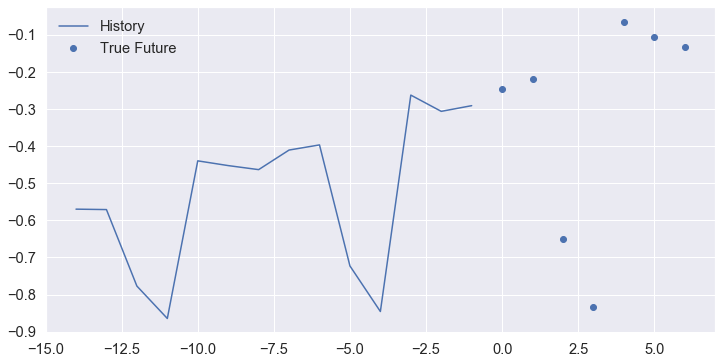

In [87]:
for x, y in train_data_multi.take(1):
    multi_step_plot(x[0], y[0], np.array([0]))

### Training

In [88]:
print(f"nb samples for training : {x_train_multi.shape[0]}")
print(f"nb samples for validation : {x_val_multi.shape[0]}")

nb samples for training : 304
nb samples for validation : 77


In [89]:
x_train_multi.shape[-2:]

(14, 9)

In [90]:
from tensorflow.keras.layers import Dense
from tensorflow.keras import Input, Model

from tcn import TCN, tcn_full_summary

batch_size, timesteps, input_dim = None, 20, 1


def get_x_y(size=1000):
    import numpy as np
    pos_indices = np.random.choice(size, size=int(size // 2), replace=False)
    x_train = np.zeros(shape=(size, timesteps, 1))
    y_train = np.zeros(shape=(size, 1))
    x_train[pos_indices, 0] = 1.0
    y_train[pos_indices, 0] = 1.0
    return x_train, y_train


i = Input(batch_shape=(batch_size, timesteps, input_dim))

o = TCN(return_sequences=False,
        dilations = [1, 2, 4])(i)  # The TCN layers are here.
o = Dense(1)(o)

m = Model(inputs=[i], outputs=[o])
m.compile(optimizer='adam', loss='mse')

tcn_full_summary(m, expand_residual_blocks=False)

x, y = get_x_y()
m.fit(x, y, epochs=10, validation_split=0.2)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 20, 1)]           0         
_________________________________________________________________
residual_block_0 (ResidualBl multiple                  8576      
_________________________________________________________________
residual_block_1 (ResidualBl multiple                  16512     
_________________________________________________________________
residual_block_2 (ResidualBl multiple                  16512     
_________________________________________________________________
lambda (Lambda)              multiple                  0         
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 41,665
Trainable params: 41,665
Non-trainable params: 0
_________________________________________________________

In [102]:
tcn_full_summary(m, expand_residual_blocks=False)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 14, 9)]           0         
_________________________________________________________________
residual_block_0 (ResidualBl multiple                  10112     
_________________________________________________________________
residual_block_1 (ResidualBl multiple                  16512     
_________________________________________________________________
residual_block_2 (ResidualBl multiple                  16512     
_________________________________________________________________


ValueError: You tried to call `count_params` on lambda, but the layer isn't built. You can build it manually via: `lambda.build(batch_input_shape)`.

In [91]:
tcn_full_summary(m, expand_residual_blocks=True)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 20, 1)]           0         
_________________________________________________________________
matching_conv1D (Conv1D)     multiple                  128       
_________________________________________________________________
activation_3 (Activation)    multiple                  0         
_________________________________________________________________
conv1D_0 (Conv1D)            multiple                  192       
_________________________________________________________________
activation (Activation)      multiple                  0         
_________________________________________________________________
spatial_dropout1d (SpatialDr multiple                  0         
_________________________________________________________________
conv1D_1 (Conv1D)            multiple                  8256  

In [92]:



lr = 2e-2
decay = 1e-6 #1e-6
momentum = 0.9 # 0.9
nesterov = True # True
patience = 250 # 30

sgd_2 = tf.keras.optimizers.SGD(lr=lr, decay=decay, momentum=momentum, 
                              nesterov=nesterov)

in_tcn = Input(batch_shape=(batch_size, timesteps, input_dim))

out_tcn = TCN(return_sequences=False,
        dilations = [1, 2, 4])(in_tcn)  # The TCN layers are here.
out_tcn = Dense(int(FUTURE_TARGET/STEP))(out_tcn)

multi_step_model = Model(inputs=[in_tcn], outputs=[out_tcn])
multi_step_model.compile(optimizer=sgd_2, loss='mae')

tcn_full_summary(multi_step_model, expand_residual_blocks=False)


'''# create model
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(Conv1D(filters=1, 
                            kernel_size=2, 
                            padding='causal',
                            dilation_rate=2, 
                            activation=None,
                            input_shape=x_train_multi.shape[-2:],
                        kernel_initializer=tf.keras.initializers.Constant(1.),
                           use_bias=False))'''

#x = Conv1D(filters, kernel_size, strides=1, padding='causal', data_format='channels_last',
#    dilation_rate=1, groups=1, activation=None)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 20, 1)]           0         
_________________________________________________________________
residual_block_0 (ResidualBl multiple                  8576      
_________________________________________________________________
residual_block_1 (ResidualBl multiple                  16512     
_________________________________________________________________
residual_block_2 (ResidualBl multiple                  16512     
_________________________________________________________________
lambda (Lambda)              multiple                  0         
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 455       
Total params: 42,055
Trainable params: 42,055
Non-trainable params: 0
_______________________________________________________

"# create model\nmulti_step_model = tf.keras.models.Sequential()\nmulti_step_model.add(Conv1D(filters=1, \n                            kernel_size=2, \n                            padding='causal',\n                            dilation_rate=2, \n                            activation=None,\n                            input_shape=x_train_multi.shape[-2:],\n                        kernel_initializer=tf.keras.initializers.Constant(1.),\n                           use_bias=False))"

In [93]:
BATCH_SIZE = 32
BATCH_SIZE_VAL = y_val_multi.shape[0]
BUFFER_SIZE = x_train_multi.shape[0]
tf.random.set_seed(0)

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, 
                                                       y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE) \
    .batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE_VAL).repeat()

print("For Training : ")
print("BATCH_SIZE :", BATCH_SIZE)
print("BUFFER_SIZE :", BUFFER_SIZE)
print("\nFor validation : ")
print("BATCH_SIZE_VAL :", BATCH_SIZE_VAL)


For Training : 
BATCH_SIZE : 32
BUFFER_SIZE : 304

For validation : 
BATCH_SIZE_VAL : 77


#### No skip connexion / internat dropout 0.4 / dropout last layer 0.4


 Run #0
Restoring model weights from the end of the best epoch.
Epoch 02438: early stopping
Run #0 : val_loss = 0.38582950830459595


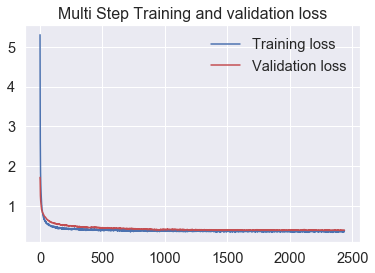

INFO:tensorflow:Assets written to: ./mdl_multi_step_pos_fr_tcn\assets


INFO:tensorflow:Assets written to: ./mdl_multi_step_pos_fr_tcn\assets



 Run #1
Restoring model weights from the end of the best epoch.
Epoch 01901: early stopping
Run #1 : val_loss = 0.423348069190979

 Run #2
Restoring model weights from the end of the best epoch.
Epoch 02444: early stopping
Run #2 : val_loss = 0.38471412658691406


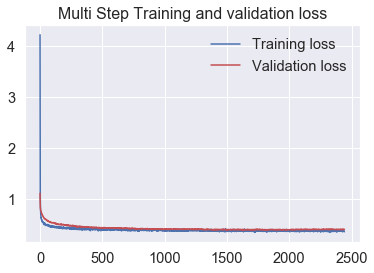

INFO:tensorflow:Assets written to: ./mdl_multi_step_pos_fr_tcn\assets


INFO:tensorflow:Assets written to: ./mdl_multi_step_pos_fr_tcn\assets


 
Final val_loss = 0.38471412658691406
Mean asbolute Error in people : 5361.959995807462
 
Wall time: 18min 45s


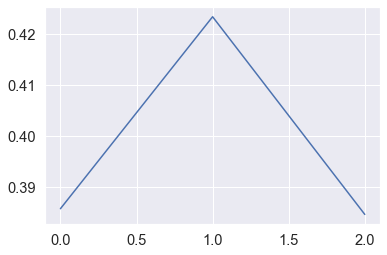

In [94]:
%%time

if mode_train:
    '''
    Run train (Batch Gradient Descent), NB_TRY times, over EPOCHS epochs 
    '''
    # Hyper-parameters
    NB_TRY = 3 #700
    EVALUATION_INTERVAL = 1
    EPOCHS = 5000
    patience = 500
    STEPS_PER_EPOCH = math.ceil(BUFFER_SIZE / BATCH_SIZE)
    # Hyper-parameters
    # lr=6e-2, decay = 1e-6, momentum = 0.9,  nesterov = True, patience = 250
    # Final val_loss = 0.18278686702251434
    # Mean asbolute Error in people : 2587.2852865276022
    # Mac : CPU times: user 1h 50min 6s, sys: 43min 33s, total: 2h 33min 39s
    # Mac : Wall time: 1h 22min 11s
    #
    # 100 TRIES / EPOCHS 5000
    # lr = 2e-2 decay = 1e-6 momentum = 0.9 nesterov = True patience = 250
    # Final val_loss = 0.13554999232292175
    # Mean asbolute Error in people : 1901.908237664341
    # Wall time: 29min 44s GPU
    
    #lr = 2e-2
    #decay = 1e-6 #1e-6
    #momentum = 0.9 # 0.9
    #nesterov = True # True
    
    
    
    optim = tf.optimizers.Adam()
    
    batch_size, timesteps, input_dim = \
        None, x_train_multi.shape[1], x_train_multi.shape[2]

    list_loss_multi = []

    for I in range(NB_TRY):
        print("")
        print(f" Run #{I}")

        tf.keras.backend.clear_session()
        # optimizer def 
        #sgd_2 = tf.keras.optimizers.SGD(lr=lr, decay=decay, momentum=momentum, 
        #                      nesterov=nesterov)

        es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', 
                                       verbose=1, patience=patience,
                                       restore_best_weights=True)
        # create model
        
        in_tcn = Input(batch_shape=(batch_size, timesteps, input_dim))

        out_tcn = TCN(return_sequences=False,
            dilations = [1, 2, 4], 
            dropout_rate=0.4)(in_tcn)  # The TCN layers are here.
        
        out_tcn = Dense(int(FUTURE_TARGET/STEP))(out_tcn)
        out_tcn = Dropout(0.4)(out_tcn)
        multi_step_model = Model(inputs=[in_tcn], outputs=[out_tcn])
        
        # compile
        multi_step_model.compile(optimizer=optim, loss='mae')
        # fitting
        multi_step_history = multi_step_model.fit(train_data_multi, 
                                                epochs=EPOCHS,
                                                steps_per_epoch=STEPS_PER_EPOCH,
                                                validation_data=val_data_multi,
                                                validation_steps=1,
                                                callbacks=[es],
                                                verbose=0)
        # eval
        mae_curr = np.min(multi_step_history.history['val_loss'])

        if (I == 0):
            list_loss_multi.append(mae_curr)

        # find the best model
        print(f"Run #{I} : val_loss = {mae_curr}")
        if (mae_curr < np.min(list_loss_multi)) | (I == 0):
            # plot history
            plot_train_history(multi_step_history,
                       'Multi Step Training and validation loss')
            # save
            if not(os.path.isdir(PATH_MDL_MULTI_STEP)):
                os.mkdir(PATH_MDL_MULTI_STEP)
            multi_step_model.save(PATH_MDL_MULTI_STEP)

        if (I != 0):   
            list_loss_multi.append(mae_curr)

    print(" ")
    print(f"Final val_loss = {np.min(list_loss_multi)}")
    print("Mean asbolute Error in people :",
          data_std[4] * np.min(list_loss_multi))
    print(" ")
    plt.plot(list_loss_multi)


In [97]:
# online version before 24/06/2021: 
#Train Mean Error  [nb of cases]:  4796.392175023473
#Val. Mean Error  [nb of cases]:  5321.471272441916
#Val. Mean nb cases  [nb of cases]:  17086.04452690167
#Val. Mean Relative Error [%]:  31.14513288352582
# new 24/06/2021
#Train Mean Error  [nb of cases]:  4691.218482315059
#Val. Mean Error  [nb of cases]:  5361.96017213067
#Val. Mean nb cases  [nb of cases]:  17086.04452690167
#Val. Mean Relative Error [%]:  31.382103468642846

y_train_multi_pred = multi_step_model.predict(x_train_multi)
mean_error_train = data_std[4] * mean_absolute_error(y_train_multi, 
                                                   y_train_multi_pred)
print("Train Mean Error  [nb of cases]: ", mean_error_train)
y_val_multi_pred = multi_step_model.predict(x_val_multi)
mean_error_val = data_std[4] * mean_absolute_error(y_val_multi, 
                                                   y_val_multi_pred)

print("Val. Mean Error  [nb of cases]: ", mean_error_val)
mean_val = np.mean(data_std[4] * y_val_multi + data_mean[4])
print("Val. Mean nb cases  [nb of cases]: ", mean_val)
print("Val. Mean Relative Error [%]: ", 100*mean_error_val/mean_val)

Train Mean Error  [nb of cases]:  4691.218482315059
Val. Mean Error  [nb of cases]:  5361.96017213067
Val. Mean nb cases  [nb of cases]:  17086.04452690167
Val. Mean Relative Error [%]:  31.382103468642846


#### No skip connexion / internal dropout 0.05 /  dropout on last layer 0.4


 Run #0
Restoring model weights from the end of the best epoch.
Epoch 04917: early stopping
Run #0 : val_loss = 0.4192551076412201


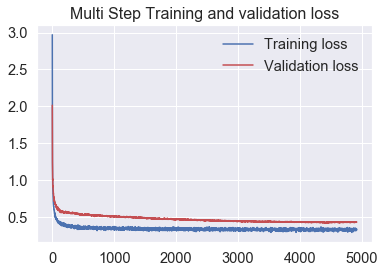

INFO:tensorflow:Assets written to: ./mdl_multi_step_pos_fr_tcn\assets


INFO:tensorflow:Assets written to: ./mdl_multi_step_pos_fr_tcn\assets



 Run #1
Restoring model weights from the end of the best epoch.
Epoch 04483: early stopping
Run #1 : val_loss = 0.43085920810699463

 Run #2
Restoring model weights from the end of the best epoch.
Epoch 02322: early stopping
Run #2 : val_loss = 0.4054498076438904


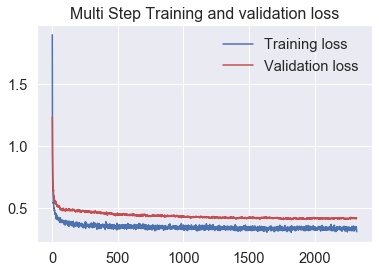

INFO:tensorflow:Assets written to: ./mdl_multi_step_pos_fr_tcn\assets


INFO:tensorflow:Assets written to: ./mdl_multi_step_pos_fr_tcn\assets


 
Final val_loss = 0.4054498076438904
Mean asbolute Error in people : 5650.963920097232
 
Wall time: 31min 19s


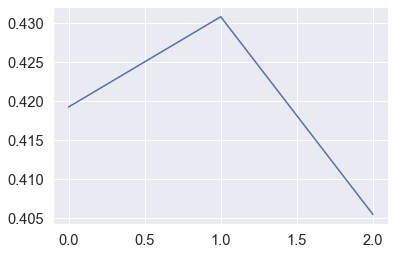

In [98]:
%%time

if mode_train:
    '''
    Run train (Batch Gradient Descent), NB_TRY times, over EPOCHS epochs 
    '''
    # Hyper-parameters
    NB_TRY = 3 #700
    EVALUATION_INTERVAL = 1
    EPOCHS = 5000
    patience = 500
    STEPS_PER_EPOCH = math.ceil(BUFFER_SIZE / BATCH_SIZE)

    
    optim = tf.optimizers.Adam()
    
    batch_size, timesteps, input_dim = \
        None, x_train_multi.shape[1], x_train_multi.shape[2]

    list_loss_multi = []

    for I in range(NB_TRY):
        print("")
        print(f" Run #{I}")

        tf.keras.backend.clear_session()
        # optimizer def 
        #sgd_2 = tf.keras.optimizers.SGD(lr=lr, decay=decay, momentum=momentum, 
        #                      nesterov=nesterov)

        es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', 
                                       verbose=1, patience=patience,
                                       restore_best_weights=True)
        # create model
        
        in_tcn = Input(batch_shape=(batch_size, timesteps, input_dim))

        out_tcn = TCN(return_sequences=False,
            dilations = [1, 2, 4], 
            dropout_rate=0.05)(in_tcn)  # The TCN layers are here.
        
        out_tcn = Dense(int(FUTURE_TARGET/STEP))(out_tcn)
        out_tcn = Dropout(0.4)(out_tcn)
        multi_step_model = Model(inputs=[in_tcn], outputs=[out_tcn])
        
        # compile
        multi_step_model.compile(optimizer=optim, loss='mae')
        # fitting
        multi_step_history = multi_step_model.fit(train_data_multi, 
                                                epochs=EPOCHS,
                                                steps_per_epoch=STEPS_PER_EPOCH,
                                                validation_data=val_data_multi,
                                                validation_steps=1,
                                                callbacks=[es],
                                                verbose=0)
        # eval
        mae_curr = np.min(multi_step_history.history['val_loss'])

        if (I == 0):
            list_loss_multi.append(mae_curr)

        # find the best model
        print(f"Run #{I} : val_loss = {mae_curr}")
        if (mae_curr < np.min(list_loss_multi)) | (I == 0):
            # plot history
            plot_train_history(multi_step_history,
                       'Multi Step Training and validation loss')
            # save
            if not(os.path.isdir(PATH_MDL_MULTI_STEP)):
                os.mkdir(PATH_MDL_MULTI_STEP)
            multi_step_model.save(PATH_MDL_MULTI_STEP)

        if (I != 0):   
            list_loss_multi.append(mae_curr)

    print(" ")
    print(f"Final val_loss = {np.min(list_loss_multi)}")
    print("Mean asbolute Error in people :",
          data_std[4] * np.min(list_loss_multi))
    print(" ")
    plt.plot(list_loss_multi)


In [100]:
# new ref : 24/06/2021
#Train Mean Error  [nb of cases]:  4691.218482315059
#Val. Mean Error  [nb of cases]:  5361.96017213067
#Val. Mean nb cases  [nb of cases]:  17086.04452690167
#Val. Mean Relative Error [%]:  31.382103468642846
# version No skip connexion / internal dropout 0.05 /  dropout on last layer 0.4
#Train Mean Error  [nb of cases]:  4434.365795614253
#Val. Mean Error  [nb of cases]:  5650.963417076767
#Val. Mean nb cases  [nb of cases]:  17086.04452690167
#Val. Mean Relative Error [%]:  33.07356133936925

y_train_multi_pred = multi_step_model.predict(x_train_multi)
mean_error_train = data_std[4] * mean_absolute_error(y_train_multi, 
                                                   y_train_multi_pred)
print("Train Mean Error  [nb of cases]: ", mean_error_train)
y_val_multi_pred = multi_step_model.predict(x_val_multi)
mean_error_val = data_std[4] * mean_absolute_error(y_val_multi, 
                                                   y_val_multi_pred)

print("Val. Mean Error  [nb of cases]: ", mean_error_val)
mean_val = np.mean(data_std[4] * y_val_multi + data_mean[4])
print("Val. Mean nb cases  [nb of cases]: ", mean_val)
print("Val. Mean Relative Error [%]: ", 100*mean_error_val/mean_val)

Train Mean Error  [nb of cases]:  4434.365795614253
Val. Mean Error  [nb of cases]:  5650.963417076767
Val. Mean nb cases  [nb of cases]:  17086.04452690167
Val. Mean Relative Error [%]:  33.07356133936925


In [105]:
tcn_full_summary(multi_step_model, expand_residual_blocks=True)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 14, 9)]           0         
_________________________________________________________________
matching_conv1D (Conv1D)     multiple                  640       
_________________________________________________________________
activation_3 (Activation)    multiple                  0         
_________________________________________________________________
conv1D_0 (Conv1D)            multiple                  1216      
_________________________________________________________________
activation (Activation)      multiple                  0         
_________________________________________________________________
spatial_dropout1d (SpatialDr multiple                  0         
_________________________________________________________________
conv1D_1 (Conv1D)            multiple                  8256  

#### No skip connexion / internal dropout 0.05 /  dropout on last layer 0.4 - check


 Run #0
Run #0 : val_loss = 0.41643664240837097


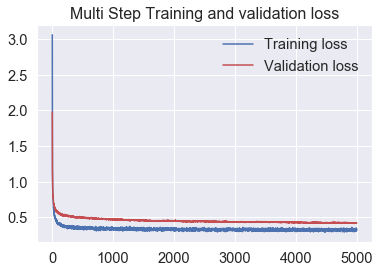

INFO:tensorflow:Assets written to: ./mdl_multi_step_pos_fr_tcn\assets


INFO:tensorflow:Assets written to: ./mdl_multi_step_pos_fr_tcn\assets



 Run #1
Restoring model weights from the end of the best epoch.
Epoch 02992: early stopping
Run #1 : val_loss = 0.4474177658557892

 Run #2
Run #2 : val_loss = 0.3917000889778137


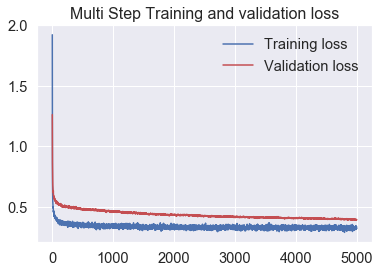

INFO:tensorflow:Assets written to: ./mdl_multi_step_pos_fr_tcn\assets


INFO:tensorflow:Assets written to: ./mdl_multi_step_pos_fr_tcn\assets


 
Final val_loss = 0.3917000889778137
Mean asbolute Error in people : 5459.3269711367575
 
Wall time: 36min 37s


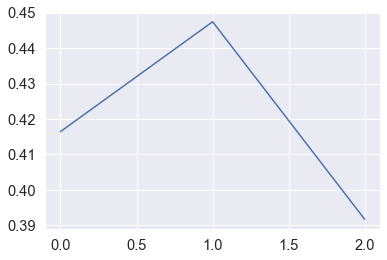

In [106]:
%%time

if mode_train:
    '''
    Run train (Batch Gradient Descent), NB_TRY times, over EPOCHS epochs 
    '''
    # Hyper-parameters
    NB_TRY = 3 #700
    EVALUATION_INTERVAL = 1
    EPOCHS = 5000
    patience = 500
    STEPS_PER_EPOCH = math.ceil(BUFFER_SIZE / BATCH_SIZE)

    
    optim = tf.optimizers.Adam()
    
    batch_size, timesteps, input_dim = \
        None, x_train_multi.shape[1], x_train_multi.shape[2]

    list_loss_multi = []

    for I in range(NB_TRY):
        print("")
        print(f" Run #{I}")

        tf.keras.backend.clear_session()
        # optimizer def 
        #sgd_2 = tf.keras.optimizers.SGD(lr=lr, decay=decay, momentum=momentum, 
        #                      nesterov=nesterov)

        es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', 
                                       verbose=1, patience=patience,
                                       restore_best_weights=True)
        # create model
        
        in_tcn = Input(batch_shape=(batch_size, timesteps, input_dim))

        out_tcn = TCN(nb_filters=64, 
                      kernel_size=2,
                      return_sequences=False,
                      dilations = [1, 2, 4], 
                      dropout_rate=0.05)(in_tcn)  # The TCN layers are here.
        
        out_tcn = Dense(int(FUTURE_TARGET/STEP))(out_tcn)
        out_tcn = Dropout(0.4)(out_tcn)
        multi_step_model = Model(inputs=[in_tcn], outputs=[out_tcn])
        
        # compile
        multi_step_model.compile(optimizer=optim, loss='mae')
        # fitting
        multi_step_history = multi_step_model.fit(train_data_multi, 
                                                epochs=EPOCHS,
                                                steps_per_epoch=STEPS_PER_EPOCH,
                                                validation_data=val_data_multi,
                                                validation_steps=1,
                                                callbacks=[es],
                                                verbose=0)
        # eval
        mae_curr = np.min(multi_step_history.history['val_loss'])

        if (I == 0):
            list_loss_multi.append(mae_curr)

        # find the best model
        print(f"Run #{I} : val_loss = {mae_curr}")
        if (mae_curr < np.min(list_loss_multi)) | (I == 0):
            # plot history
            plot_train_history(multi_step_history,
                       'Multi Step Training and validation loss')
            # save
            if not(os.path.isdir(PATH_MDL_MULTI_STEP)):
                os.mkdir(PATH_MDL_MULTI_STEP)
            multi_step_model.save(PATH_MDL_MULTI_STEP)

        if (I != 0):   
            list_loss_multi.append(mae_curr)

    print(" ")
    print(f"Final val_loss = {np.min(list_loss_multi)}")
    print("Mean asbolute Error in people :",
          data_std[4] * np.min(list_loss_multi))
    print(" ")
    plt.plot(list_loss_multi)


In [107]:
# new ref : 24/06/2021
#Train Mean Error  [nb of cases]:  4691.218482315059
#Val. Mean Error  [nb of cases]:  5361.96017213067
#Val. Mean nb cases  [nb of cases]:  17086.04452690167
#Val. Mean Relative Error [%]:  31.382103468642846
# version No skip connexion / internal dropout 0.05 /  dropout on last layer 0.4
#Train Mean Error  [nb of cases]:  4434.365795614253
#Val. Mean Error  [nb of cases]:  5650.963417076767
#Val. Mean nb cases  [nb of cases]:  17086.04452690167
#Val. Mean Relative Error [%]:  33.07356133936925

y_train_multi_pred = multi_step_model.predict(x_train_multi)
mean_error_train = data_std[4] * mean_absolute_error(y_train_multi, 
                                                   y_train_multi_pred)
print("Train Mean Error  [nb of cases]: ", mean_error_train)
y_val_multi_pred = multi_step_model.predict(x_val_multi)
mean_error_val = data_std[4] * mean_absolute_error(y_val_multi, 
                                                   y_val_multi_pred)

print("Val. Mean Error  [nb of cases]: ", mean_error_val)
mean_val = np.mean(data_std[4] * y_val_multi + data_mean[4])
print("Val. Mean nb cases  [nb of cases]: ", mean_val)
print("Val. Mean Relative Error [%]: ", 100*mean_error_val/mean_val)

Train Mean Error  [nb of cases]:  4388.869277969514
Val. Mean Error  [nb of cases]:  5519.009004830796
Val. Mean nb cases  [nb of cases]:  17086.04452690167
Val. Mean Relative Error [%]:  32.301267833764655


In [108]:
tcn_full_summary(multi_step_model, expand_residual_blocks=True)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 14, 9)]           0         
_________________________________________________________________
matching_conv1D (Conv1D)     multiple                  640       
_________________________________________________________________
activation_3 (Activation)    multiple                  0         
_________________________________________________________________
conv1D_0 (Conv1D)            multiple                  1216      
_________________________________________________________________
activation (Activation)      multiple                  0         
_________________________________________________________________
spatial_dropout1d (SpatialDr multiple                  0         
_________________________________________________________________
conv1D_1 (Conv1D)            multiple                  8256  

#### No skip connexion / internal dropout 0.05 /  dropout before dense 0.4


 Run #0
Restoring model weights from the end of the best epoch.
Epoch 00998: early stopping
Run #0 : val_loss = 0.38647183775901794


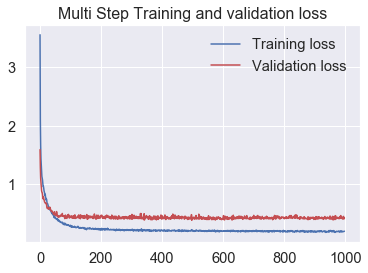

INFO:tensorflow:Assets written to: ./mdl_multi_step_pos_fr_tcn\assets


INFO:tensorflow:Assets written to: ./mdl_multi_step_pos_fr_tcn\assets



 Run #1
Restoring model weights from the end of the best epoch.
Epoch 01130: early stopping
Run #1 : val_loss = 0.4335791766643524

 Run #2
Restoring model weights from the end of the best epoch.
Epoch 01101: early stopping
Run #2 : val_loss = 0.37555256485939026


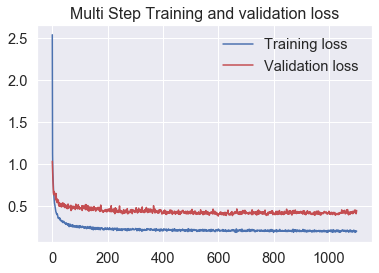

INFO:tensorflow:Assets written to: ./mdl_multi_step_pos_fr_tcn\assets


INFO:tensorflow:Assets written to: ./mdl_multi_step_pos_fr_tcn\assets


 
Final val_loss = 0.37555256485939026
Mean asbolute Error in people : 5234.270565949717
 
Wall time: 8min 54s


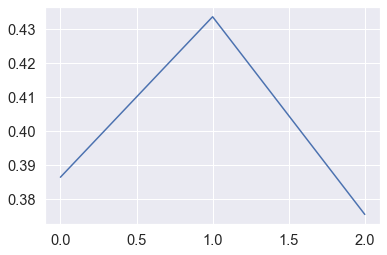

In [119]:
%%time

if mode_train:
    '''
    Run train (Batch Gradient Descent), NB_TRY times, over EPOCHS epochs 
    '''
    # Hyper-parameters
    NB_TRY = 3 #700
    EVALUATION_INTERVAL = 1
    EPOCHS = 5000
    patience = 500
    STEPS_PER_EPOCH = math.ceil(BUFFER_SIZE / BATCH_SIZE)

    
    optim = tf.optimizers.Adam()
    
    batch_size, timesteps, input_dim = \
        None, x_train_multi.shape[1], x_train_multi.shape[2]

    list_loss_multi = []

    for I in range(NB_TRY):
        print("")
        print(f" Run #{I}")

        tf.keras.backend.clear_session()
        # optimizer def 
        #sgd_2 = tf.keras.optimizers.SGD(lr=lr, decay=decay, momentum=momentum, 
        #                      nesterov=nesterov)

        es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', 
                                       verbose=1, patience=patience,
                                       restore_best_weights=True)
        # create model
        
        in_tcn = Input(batch_shape=(batch_size, timesteps, input_dim))

        out_tcn = TCN(nb_filters=64, 
                      kernel_size=2,
                      return_sequences=False,
                      dilations = [1, 2, 4], 
                      dropout_rate=0.05)(in_tcn)  # The TCN layers are here.
        out_tcn = Dropout(0.4)(out_tcn)
        out_tcn = Dense(int(FUTURE_TARGET/STEP))(out_tcn)
        multi_step_model = Model(inputs=[in_tcn], outputs=[out_tcn])
        
        # compile
        multi_step_model.compile(optimizer=optim, loss='mae')
        # fitting
        multi_step_history = multi_step_model.fit(train_data_multi, 
                                                epochs=EPOCHS,
                                                steps_per_epoch=STEPS_PER_EPOCH,
                                                validation_data=val_data_multi,
                                                validation_steps=1,
                                                callbacks=[es],
                                                verbose=0)
        # eval
        mae_curr = np.min(multi_step_history.history['val_loss'])

        if (I == 0):
            list_loss_multi.append(mae_curr)

        # find the best model
        print(f"Run #{I} : val_loss = {mae_curr}")
        if (mae_curr < np.min(list_loss_multi)) | (I == 0):
            # plot history
            plot_train_history(multi_step_history,
                       'Multi Step Training and validation loss')
            # save
            if not(os.path.isdir(PATH_MDL_MULTI_STEP)):
                os.mkdir(PATH_MDL_MULTI_STEP)
            multi_step_model.save(PATH_MDL_MULTI_STEP)

        if (I != 0):   
            list_loss_multi.append(mae_curr)

    print(" ")
    print(f"Final val_loss = {np.min(list_loss_multi)}")
    print("Mean asbolute Error in people :",
          data_std[4] * np.min(list_loss_multi))
    print(" ")
    plt.plot(list_loss_multi)


In [120]:
# new ref : 24/06/2021
#Train Mean Error  [nb of cases]:  4691.218482315059
#Val. Mean Error  [nb of cases]:  5361.96017213067
#Val. Mean nb cases  [nb of cases]:  17086.04452690167
#Val. Mean Relative Error [%]:  31.382103468642846
# version No skip connexion / internal dropout 0.05 /  dropout on last layer 0.4
#Train Mean Error  [nb of cases]:  4434.365795614253
#Val. Mean Error  [nb of cases]:  5650.963417076767
#Val. Mean nb cases  [nb of cases]:  17086.04452690167
#Val. Mean Relative Error [%]:  33.07356133936925

y_train_multi_pred = multi_step_model.predict(x_train_multi)
mean_error_train = data_std[4] * mean_absolute_error(y_train_multi, 
                                                   y_train_multi_pred)
print("Train Mean Error  [nb of cases]: ", mean_error_train)
y_val_multi_pred = multi_step_model.predict(x_val_multi)
mean_error_val = data_std[4] * mean_absolute_error(y_val_multi, 
                                                   y_val_multi_pred)

print("Val. Mean Error  [nb of cases]: ", mean_error_val)
mean_val = np.mean(data_std[4] * y_val_multi + data_mean[4])
print("Val. Mean nb cases  [nb of cases]: ", mean_val)
print("Val. Mean Relative Error [%]: ", 100*mean_error_val/mean_val)

Train Mean Error  [nb of cases]:  1506.5935126808192
Val. Mean Error  [nb of cases]:  5234.270600288743
Val. Mean nb cases  [nb of cases]:  17086.04452690167
Val. Mean Relative Error [%]:  30.634770921072324


#### used  skip connexion / dropout int 0.05 out 0.4 


 Run #0
Restoring model weights from the end of the best epoch.
Epoch 04051: early stopping
Run #0 : val_loss = 0.38944894075393677


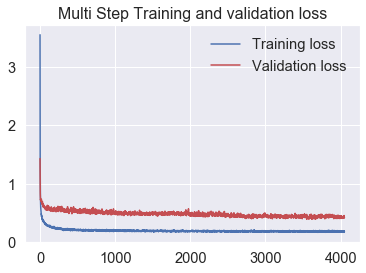

INFO:tensorflow:Assets written to: ./mdl_multi_step_pos_fr_tcn\assets


INFO:tensorflow:Assets written to: ./mdl_multi_step_pos_fr_tcn\assets



 Run #1
Restoring model weights from the end of the best epoch.
Epoch 02611: early stopping
Run #1 : val_loss = 0.3379580080509186


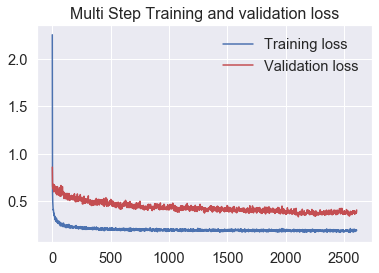

INFO:tensorflow:Assets written to: ./mdl_multi_step_pos_fr_tcn\assets


INFO:tensorflow:Assets written to: ./mdl_multi_step_pos_fr_tcn\assets



 Run #2
Restoring model weights from the end of the best epoch.
Epoch 00710: early stopping
Run #2 : val_loss = 0.4329967200756073
 
Final val_loss = 0.3379580080509186
Mean asbolute Error in people : 4710.295760409023
 
Wall time: 20min 18s


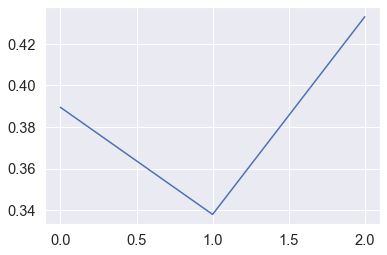

In [127]:
%%time

if mode_train:
    '''
    Run train (Batch Gradient Descent), NB_TRY times, over EPOCHS epochs 
    '''
    # Hyper-parameters
    NB_TRY = 3 #700
    EVALUATION_INTERVAL = 1
    EPOCHS = 5000
    patience = 500
    STEPS_PER_EPOCH = math.ceil(BUFFER_SIZE / BATCH_SIZE)

    
    optim = tf.optimizers.Adam()
    
    batch_size, timesteps, input_dim = \
        None, x_train_multi.shape[1], x_train_multi.shape[2]

    list_loss_multi = []

    for I in range(NB_TRY):
        print("")
        print(f" Run #{I}")

        tf.keras.backend.clear_session()
        # optimizer def 
        #sgd_2 = tf.keras.optimizers.SGD(lr=lr, decay=decay, momentum=momentum, 
        #                      nesterov=nesterov)

        es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', 
                                       verbose=1, patience=patience,
                                       restore_best_weights=True)
        # create model
        
        in_tcn = Input(batch_shape=(batch_size, timesteps, input_dim))

        out_tcn = TCN(nb_filters=64, 
                      kernel_size=2,
                      use_skip_connections=True,
                      return_sequences=False,
                      dilations = [1, 2, 4], 
                      dropout_rate=0.05)(in_tcn)  # The TCN layers are here.
        out_tcn = Dropout(0.4)(out_tcn)
        out_tcn = Dense(int(FUTURE_TARGET/STEP))(out_tcn)
        multi_step_model = Model(inputs=[in_tcn], outputs=[out_tcn])
        
        # compile
        multi_step_model.compile(optimizer=optim, loss='mae')
        # fitting
        multi_step_history = multi_step_model.fit(train_data_multi, 
                                                epochs=EPOCHS,
                                                steps_per_epoch=STEPS_PER_EPOCH,
                                                validation_data=val_data_multi,
                                                validation_steps=1,
                                                callbacks=[es],
                                                verbose=0)
        # eval
        mae_curr = np.min(multi_step_history.history['val_loss'])

        if (I == 0):
            list_loss_multi.append(mae_curr)

        # find the best model
        print(f"Run #{I} : val_loss = {mae_curr}")
        if (mae_curr < np.min(list_loss_multi)) | (I == 0):
            # plot history
            plot_train_history(multi_step_history,
                       'Multi Step Training and validation loss')
            # save
            if not(os.path.isdir(PATH_MDL_MULTI_STEP)):
                os.mkdir(PATH_MDL_MULTI_STEP)
            multi_step_model.save(PATH_MDL_MULTI_STEP)

        if (I != 0):   
            list_loss_multi.append(mae_curr)

    print(" ")
    print(f"Final val_loss = {np.min(list_loss_multi)}")
    print("Mean asbolute Error in people :",
          data_std[4] * np.min(list_loss_multi))
    print(" ")
    plt.plot(list_loss_multi)


In [128]:
# new ref : 24/06/2021
#Train Mean Error  [nb of cases]:  4691.218482315059
#Val. Mean Error  [nb of cases]:  5361.96017213067
#Val. Mean nb cases  [nb of cases]:  17086.04452690167
#Val. Mean Relative Error [%]:  31.382103468642846
# version No skip connexion / internal dropout 0.05 /  dropout on last layer 0.4
#Train Mean Error  [nb of cases]:  4434.365795614253
#Val. Mean Error  [nb of cases]:  5650.963417076767
#Val. Mean nb cases  [nb of cases]:  17086.04452690167
#Val. Mean Relative Error [%]:  33.07356133936925

y_train_multi_pred = multi_step_model.predict(x_train_multi)
mean_error_train = data_std[4] * mean_absolute_error(y_train_multi, 
                                                   y_train_multi_pred)
print("Train Mean Error  [nb of cases]: ", mean_error_train)
y_val_multi_pred = multi_step_model.predict(x_val_multi)
mean_error_val = data_std[4] * mean_absolute_error(y_val_multi, 
                                                   y_val_multi_pred)

print("Val. Mean Error  [nb of cases]: ", mean_error_val)
mean_val = np.mean(data_std[4] * y_val_multi + data_mean[4])
print("Val. Mean nb cases  [nb of cases]: ", mean_val)
print("Val. Mean Relative Error [%]: ", 100*mean_error_val/mean_val)

Train Mean Error  [nb of cases]:  1842.8249280662844
Val. Mean Error  [nb of cases]:  6034.899541583332
Val. Mean nb cases  [nb of cases]:  17086.04452690167
Val. Mean Relative Error [%]:  35.32063569237158


In [129]:
tcn_full_summary(multi_step_model, expand_residual_blocks=True)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 14, 9)]           0         
_________________________________________________________________
matching_conv1D (Conv1D)     multiple                  640       
_________________________________________________________________
activation_3 (Activation)    multiple                  0         
_________________________________________________________________
conv1D_0 (Conv1D)            multiple                  1216      
_________________________________________________________________
activation (Activation)      multiple                  0         
_________________________________________________________________
spatial_dropout1d (SpatialDr multiple                  0         
_________________________________________________________________
conv1D_1 (Conv1D)            multiple                  8256  

#### used  skip connexion / dropout int 0.4 out 0.4 


 Run #0
Restoring model weights from the end of the best epoch.
Epoch 03188: early stopping
Run #0 : val_loss = 0.3149929642677307


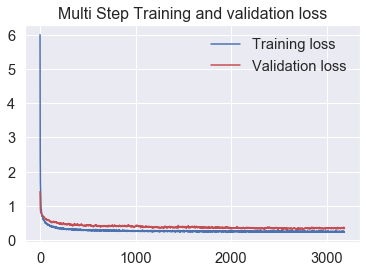

INFO:tensorflow:Assets written to: ./mdl_multi_step_pos_fr_tcn\assets


INFO:tensorflow:Assets written to: ./mdl_multi_step_pos_fr_tcn\assets



 Run #1
Restoring model weights from the end of the best epoch.
Epoch 03702: early stopping
Run #1 : val_loss = 0.33913394808769226

 Run #2
Restoring model weights from the end of the best epoch.
Epoch 03182: early stopping
Run #2 : val_loss = 0.29694056510925293


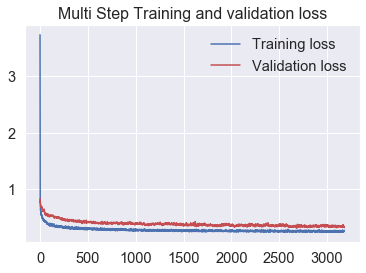

INFO:tensorflow:Assets written to: ./mdl_multi_step_pos_fr_tcn\assets


INFO:tensorflow:Assets written to: ./mdl_multi_step_pos_fr_tcn\assets


 
Final val_loss = 0.29694056510925293
Mean asbolute Error in people : 4138.61441838313
 
Wall time: 27min 20s


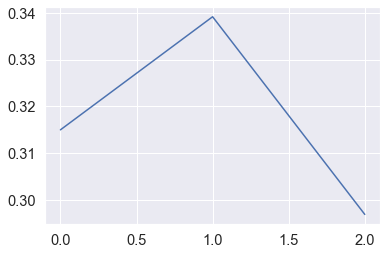

In [130]:
%%time

if mode_train:
    '''
    Run train (Batch Gradient Descent), NB_TRY times, over EPOCHS epochs 
    '''
    # Hyper-parameters
    NB_TRY = 3 #700
    EVALUATION_INTERVAL = 1
    EPOCHS = 5000
    patience = 500
    STEPS_PER_EPOCH = math.ceil(BUFFER_SIZE / BATCH_SIZE)

    
    optim = tf.optimizers.Adam()
    
    batch_size, timesteps, input_dim = \
        None, x_train_multi.shape[1], x_train_multi.shape[2]

    list_loss_multi = []

    for I in range(NB_TRY):
        print("")
        print(f" Run #{I}")

        tf.keras.backend.clear_session()
        # optimizer def 
        #sgd_2 = tf.keras.optimizers.SGD(lr=lr, decay=decay, momentum=momentum, 
        #                      nesterov=nesterov)

        es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', 
                                       verbose=1, patience=patience,
                                       restore_best_weights=True)
        # create model
        
        in_tcn = Input(batch_shape=(batch_size, timesteps, input_dim))

        out_tcn = TCN(nb_filters=64, 
                      kernel_size=2,
                      use_skip_connections=True,
                      return_sequences=False,
                      dilations = [1, 2, 4], 
                      dropout_rate=0.4)(in_tcn)  # The TCN layers are here.
        out_tcn = Dropout(0.4)(out_tcn)
        out_tcn = Dense(int(FUTURE_TARGET/STEP))(out_tcn)
        multi_step_model = Model(inputs=[in_tcn], outputs=[out_tcn])
        
        # compile
        multi_step_model.compile(optimizer=optim, loss='mae')
        # fitting
        multi_step_history = multi_step_model.fit(train_data_multi, 
                                                epochs=EPOCHS,
                                                steps_per_epoch=STEPS_PER_EPOCH,
                                                validation_data=val_data_multi,
                                                validation_steps=1,
                                                callbacks=[es],
                                                verbose=0)
        # eval
        mae_curr = np.min(multi_step_history.history['val_loss'])

        if (I == 0):
            list_loss_multi.append(mae_curr)

        # find the best model
        print(f"Run #{I} : val_loss = {mae_curr}")
        if (mae_curr < np.min(list_loss_multi)) | (I == 0):
            # plot history
            plot_train_history(multi_step_history,
                       'Multi Step Training and validation loss')
            # save
            if not(os.path.isdir(PATH_MDL_MULTI_STEP)):
                os.mkdir(PATH_MDL_MULTI_STEP)
            multi_step_model.save(PATH_MDL_MULTI_STEP)

        if (I != 0):   
            list_loss_multi.append(mae_curr)

    print(" ")
    print(f"Final val_loss = {np.min(list_loss_multi)}")
    print("Mean asbolute Error in people :",
          data_std[4] * np.min(list_loss_multi))
    print(" ")
    plt.plot(list_loss_multi)


In [131]:
# new ref : 24/06/2021
#Train Mean Error  [nb of cases]:  4691.218482315059
#Val. Mean Error  [nb of cases]:  5361.96017213067
#Val. Mean nb cases  [nb of cases]:  17086.04452690167
#Val. Mean Relative Error [%]:  31.382103468642846
# version No skip connexion / internal dropout 0.05 /  dropout on last layer 0.4
#Train Mean Error  [nb of cases]:  4434.365795614253
#Val. Mean Error  [nb of cases]:  5650.963417076767
#Val. Mean nb cases  [nb of cases]:  17086.04452690167
#Val. Mean Relative Error [%]:  33.07356133936925

y_train_multi_pred = multi_step_model.predict(x_train_multi)
mean_error_train = data_std[4] * mean_absolute_error(y_train_multi, 
                                                   y_train_multi_pred)
print("Train Mean Error  [nb of cases]: ", mean_error_train)
y_val_multi_pred = multi_step_model.predict(x_val_multi)
mean_error_val = data_std[4] * mean_absolute_error(y_val_multi, 
                                                   y_val_multi_pred)

print("Val. Mean Error  [nb of cases]: ", mean_error_val)
mean_val = np.mean(data_std[4] * y_val_multi + data_mean[4])
print("Val. Mean nb cases  [nb of cases]: ", mean_val)
print("Val. Mean Relative Error [%]: ", 100*mean_error_val/mean_val)

Train Mean Error  [nb of cases]:  2137.3979221592613
Val. Mean Error  [nb of cases]:  4138.614380141871
Val. Mean nb cases  [nb of cases]:  17086.04452690167
Val. Mean Relative Error [%]:  24.222191236981132


#### used  skip connexion / dropout int 0.4 out 0.4 / layer norm


 Run #0
Restoring model weights from the end of the best epoch.
Epoch 03877: early stopping
Run #0 : val_loss = 0.3857046067714691


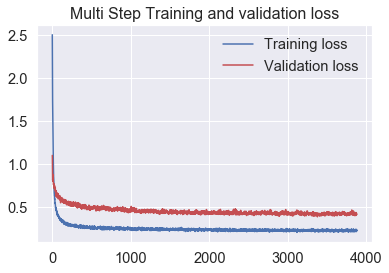

INFO:tensorflow:Assets written to: ./mdl_multi_step_pos_fr_tcn\assets


INFO:tensorflow:Assets written to: ./mdl_multi_step_pos_fr_tcn\assets



 Run #1
Restoring model weights from the end of the best epoch.
Epoch 03701: early stopping
Run #1 : val_loss = 0.3745135962963104


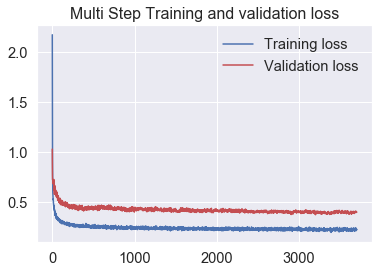

INFO:tensorflow:Assets written to: ./mdl_multi_step_pos_fr_tcn\assets


INFO:tensorflow:Assets written to: ./mdl_multi_step_pos_fr_tcn\assets



 Run #2
Restoring model weights from the end of the best epoch.
Epoch 04729: early stopping
Run #2 : val_loss = 0.36240673065185547


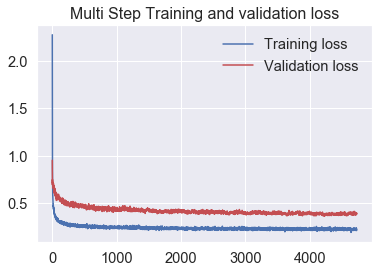

INFO:tensorflow:Assets written to: ./mdl_multi_step_pos_fr_tcn\assets


INFO:tensorflow:Assets written to: ./mdl_multi_step_pos_fr_tcn\assets


 
Final val_loss = 0.36240673065185547
Mean asbolute Error in people : 5051.050267392798
 
Wall time: 39min 16s


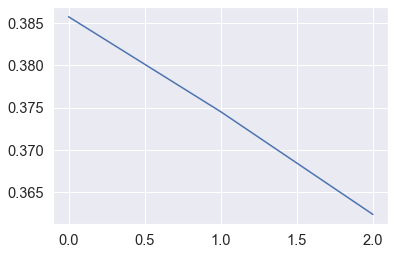

In [142]:
%%time

if mode_train:
    '''
    Run train (Batch Gradient Descent), NB_TRY times, over EPOCHS epochs 
    '''
    # Hyper-parameters
    NB_TRY = 3 #700
    EVALUATION_INTERVAL = 1
    EPOCHS = 5000
    patience = 500
    STEPS_PER_EPOCH = math.ceil(BUFFER_SIZE / BATCH_SIZE)

    
    optim = tf.optimizers.Adam()
    
    batch_size, timesteps, input_dim = \
        None, x_train_multi.shape[1], x_train_multi.shape[2]

    list_loss_multi = []

    for I in range(NB_TRY):
        print("")
        print(f" Run #{I}")

        tf.keras.backend.clear_session()
        # optimizer def 
        #sgd_2 = tf.keras.optimizers.SGD(lr=lr, decay=decay, momentum=momentum, 
        #                      nesterov=nesterov)

        es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', 
                                       verbose=1, patience=patience,
                                       restore_best_weights=True)
        # create model
        
        in_tcn = Input(batch_shape=(batch_size, timesteps, input_dim))

        out_tcn = TCN(nb_filters=64, 
                      kernel_size=2,
                      use_skip_connections=True,
                      use_layer_norm=True,
                      return_sequences=False,
                      dilations = [1, 2, 4], 
                      dropout_rate=0.4)(in_tcn)  # The TCN layers are here.
        out_tcn = Dropout(0.4)(out_tcn)
        out_tcn = Dense(int(FUTURE_TARGET/STEP))(out_tcn)
        multi_step_model = Model(inputs=[in_tcn], outputs=[out_tcn])
        
        # compile
        multi_step_model.compile(optimizer=optim, loss='mae')
        # fitting
        multi_step_history = multi_step_model.fit(train_data_multi, 
                                                epochs=EPOCHS,
                                                steps_per_epoch=STEPS_PER_EPOCH,
                                                validation_data=val_data_multi,
                                                validation_steps=1,
                                                callbacks=[es],
                                                verbose=0)
        # eval
        mae_curr = np.min(multi_step_history.history['val_loss'])

        if (I == 0):
            list_loss_multi.append(mae_curr)

        # find the best model
        print(f"Run #{I} : val_loss = {mae_curr}")
        if (mae_curr < np.min(list_loss_multi)) | (I == 0):
            # plot history
            plot_train_history(multi_step_history,
                       'Multi Step Training and validation loss')
            # save
            if not(os.path.isdir(PATH_MDL_MULTI_STEP)):
                os.mkdir(PATH_MDL_MULTI_STEP)
            multi_step_model.save(PATH_MDL_MULTI_STEP)

        if (I != 0):   
            list_loss_multi.append(mae_curr)

    print(" ")
    print(f"Final val_loss = {np.min(list_loss_multi)}")
    print("Mean asbolute Error in people :",
          data_std[4] * np.min(list_loss_multi))
    print(" ")
    plt.plot(list_loss_multi)


In [143]:
# new ref : 24/06/2021
#Train Mean Error  [nb of cases]:  4691.218482315059
#Val. Mean Error  [nb of cases]:  5361.96017213067
#Val. Mean nb cases  [nb of cases]:  17086.04452690167
#Val. Mean Relative Error [%]:  31.382103468642846
# version No skip connexion / internal dropout 0.05 /  dropout on last layer 0.4
#Train Mean Error  [nb of cases]:  4434.365795614253
#Val. Mean Error  [nb of cases]:  5650.963417076767
#Val. Mean nb cases  [nb of cases]:  17086.04452690167
#Val. Mean Relative Error [%]:  33.07356133936925

y_train_multi_pred = multi_step_model.predict(x_train_multi)
mean_error_train = data_std[4] * mean_absolute_error(y_train_multi, 
                                                   y_train_multi_pred)
print("Train Mean Error  [nb of cases]: ", mean_error_train)
y_val_multi_pred = multi_step_model.predict(x_val_multi)
mean_error_val = data_std[4] * mean_absolute_error(y_val_multi, 
                                                   y_val_multi_pred)

print("Val. Mean Error  [nb of cases]: ", mean_error_val)
mean_val = np.mean(data_std[4] * y_val_multi + data_mean[4])
print("Val. Mean nb cases  [nb of cases]: ", mean_val)
print("Val. Mean Relative Error [%]: ", 100*mean_error_val/mean_val)

Train Mean Error  [nb of cases]:  1366.0923705810787
Val. Mean Error  [nb of cases]:  5051.04987322941
Val. Mean nb cases  [nb of cases]:  17086.04452690167
Val. Mean Relative Error [%]:  29.5624295329245


#### used  skip connexion / dropout int 0.4 out 0.4 / batch norm


 Run #0
Restoring model weights from the end of the best epoch.
Epoch 02124: early stopping
Run #0 : val_loss = 0.43891555070877075


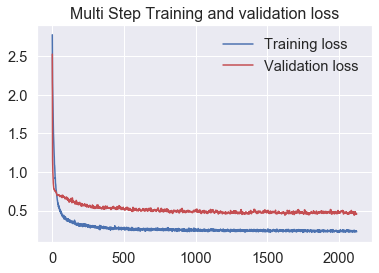

INFO:tensorflow:Assets written to: ./mdl_multi_step_pos_fr_tcn\assets


INFO:tensorflow:Assets written to: ./mdl_multi_step_pos_fr_tcn\assets



 Run #1
Restoring model weights from the end of the best epoch.
Epoch 01649: early stopping
Run #1 : val_loss = 0.41525012254714966


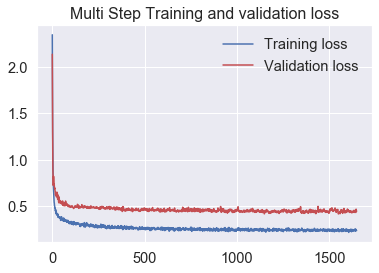

INFO:tensorflow:Assets written to: ./mdl_multi_step_pos_fr_tcn\assets


INFO:tensorflow:Assets written to: ./mdl_multi_step_pos_fr_tcn\assets



 Run #2
Restoring model weights from the end of the best epoch.
Epoch 02260: early stopping
Run #2 : val_loss = 0.3802075684070587


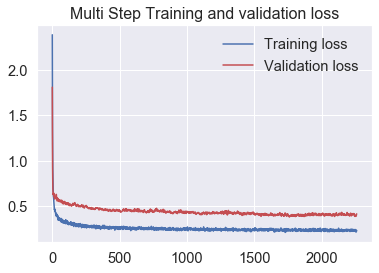

INFO:tensorflow:Assets written to: ./mdl_multi_step_pos_fr_tcn\assets


INFO:tensorflow:Assets written to: ./mdl_multi_step_pos_fr_tcn\assets


 
Final val_loss = 0.3802075684070587
Mean asbolute Error in people : 5299.149760858359
 
Wall time: 24min 5s


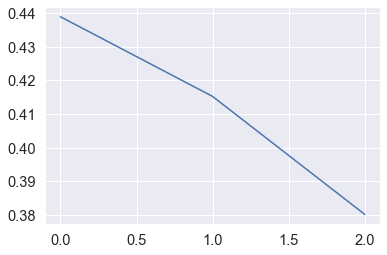

In [145]:
%%time

if mode_train:
    '''
    Run train (Batch Gradient Descent), NB_TRY times, over EPOCHS epochs 
    '''
    # Hyper-parameters
    NB_TRY = 3 #700
    EVALUATION_INTERVAL = 1
    EPOCHS = 5000
    patience = 500
    STEPS_PER_EPOCH = math.ceil(BUFFER_SIZE / BATCH_SIZE)

    
    optim = tf.optimizers.Adam()
    
    batch_size, timesteps, input_dim = \
        None, x_train_multi.shape[1], x_train_multi.shape[2]

    list_loss_multi = []

    for I in range(NB_TRY):
        print("")
        print(f" Run #{I}")

        tf.keras.backend.clear_session()
        # optimizer def 
        #sgd_2 = tf.keras.optimizers.SGD(lr=lr, decay=decay, momentum=momentum, 
        #                      nesterov=nesterov)

        es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', 
                                       verbose=1, patience=patience,
                                       restore_best_weights=True)
        # create model
        
        in_tcn = Input(batch_shape=(batch_size, timesteps, input_dim))

        out_tcn = TCN(nb_filters=64, 
                      kernel_size=2,
                      use_skip_connections=True,
                      use_batch_norm=True,
                      return_sequences=False,
                      dilations = [1, 2, 4], 
                      dropout_rate=0.4)(in_tcn)  # The TCN layers are here.
        out_tcn = Dropout(0.4)(out_tcn)
        out_tcn = Dense(int(FUTURE_TARGET/STEP))(out_tcn)
        multi_step_model = Model(inputs=[in_tcn], outputs=[out_tcn])
        
        # compile
        multi_step_model.compile(optimizer=optim, loss='mae')
        # fitting
        multi_step_history = multi_step_model.fit(train_data_multi, 
                                                epochs=EPOCHS,
                                                steps_per_epoch=STEPS_PER_EPOCH,
                                                validation_data=val_data_multi,
                                                validation_steps=1,
                                                callbacks=[es],
                                                verbose=0)
        # eval
        mae_curr = np.min(multi_step_history.history['val_loss'])

        if (I == 0):
            list_loss_multi.append(mae_curr)

        # find the best model
        print(f"Run #{I} : val_loss = {mae_curr}")
        if (mae_curr < np.min(list_loss_multi)) | (I == 0):
            # plot history
            plot_train_history(multi_step_history,
                       'Multi Step Training and validation loss')
            # save
            if not(os.path.isdir(PATH_MDL_MULTI_STEP)):
                os.mkdir(PATH_MDL_MULTI_STEP)
            multi_step_model.save(PATH_MDL_MULTI_STEP)

        if (I != 0):   
            list_loss_multi.append(mae_curr)

    print(" ")
    print(f"Final val_loss = {np.min(list_loss_multi)}")
    print("Mean asbolute Error in people :",
          data_std[4] * np.min(list_loss_multi))
    print(" ")
    plt.plot(list_loss_multi)


In [146]:
# new ref : 24/06/2021
#Train Mean Error  [nb of cases]:  4691.218482315059
#Val. Mean Error  [nb of cases]:  5361.96017213067
#Val. Mean nb cases  [nb of cases]:  17086.04452690167
#Val. Mean Relative Error [%]:  31.382103468642846
# version No skip connexion / internal dropout 0.05 /  dropout on last layer 0.4
#Train Mean Error  [nb of cases]:  4434.365795614253
#Val. Mean Error  [nb of cases]:  5650.963417076767
#Val. Mean nb cases  [nb of cases]:  17086.04452690167
#Val. Mean Relative Error [%]:  33.07356133936925

y_train_multi_pred = multi_step_model.predict(x_train_multi)
mean_error_train = data_std[4] * mean_absolute_error(y_train_multi, 
                                                   y_train_multi_pred)
print("Train Mean Error  [nb of cases]: ", mean_error_train)
y_val_multi_pred = multi_step_model.predict(x_val_multi)
mean_error_val = data_std[4] * mean_absolute_error(y_val_multi, 
                                                   y_val_multi_pred)

print("Val. Mean Error  [nb of cases]: ", mean_error_val)
mean_val = np.mean(data_std[4] * y_val_multi + data_mean[4])
print("Val. Mean nb cases  [nb of cases]: ", mean_val)
print("Val. Mean Relative Error [%]: ", 100*mean_error_val/mean_val)

Train Mean Error  [nb of cases]:  1662.611022428041
Val. Mean Error  [nb of cases]:  5299.150045949528
Val. Mean nb cases  [nb of cases]:  17086.04452690167
Val. Mean Relative Error [%]:  31.0144927786306


#### used  skip connexion / dropout int 0.3 out 0.3


 Run #0
Restoring model weights from the end of the best epoch.
Epoch 02588: early stopping
Run #0 : val_loss = 0.3314370810985565


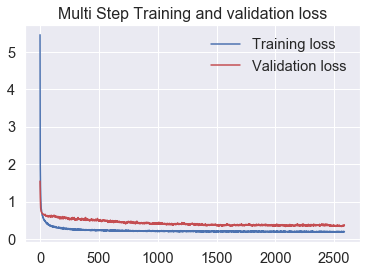

INFO:tensorflow:Assets written to: ./mdl_multi_step_pos_fr_tcn\assets


INFO:tensorflow:Assets written to: ./mdl_multi_step_pos_fr_tcn\assets



 Run #1
Restoring model weights from the end of the best epoch.
Epoch 03646: early stopping
Run #1 : val_loss = 0.33598387241363525

 Run #2
Restoring model weights from the end of the best epoch.
Epoch 01683: early stopping
Run #2 : val_loss = 0.3497719466686249
 
Final val_loss = 0.3314370810985565
Mean asbolute Error in people : 4619.410224792361
 
Wall time: 21min 20s


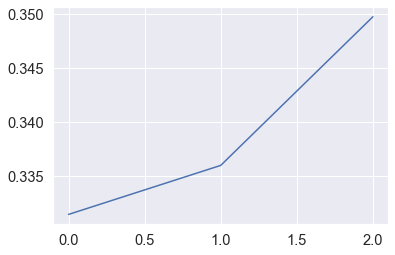

In [150]:
%%time

if mode_train:
    '''
    Run train (Batch Gradient Descent), NB_TRY times, over EPOCHS epochs 
    '''
    # Hyper-parameters
    NB_TRY = 3 #700
    EVALUATION_INTERVAL = 1
    EPOCHS = 5000
    patience = 500
    STEPS_PER_EPOCH = math.ceil(BUFFER_SIZE / BATCH_SIZE)

    
    optim = tf.optimizers.Adam()
    
    batch_size, timesteps, input_dim = \
        None, x_train_multi.shape[1], x_train_multi.shape[2]

    list_loss_multi = []

    for I in range(NB_TRY):
        print("")
        print(f" Run #{I}")

        tf.keras.backend.clear_session()
        # optimizer def 
        #sgd_2 = tf.keras.optimizers.SGD(lr=lr, decay=decay, momentum=momentum, 
        #                      nesterov=nesterov)

        es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', 
                                       verbose=1, patience=patience,
                                       restore_best_weights=True)
        # create model
        
        in_tcn = Input(batch_shape=(batch_size, timesteps, input_dim))

        out_tcn = TCN(nb_filters=64, 
                      kernel_size=2,
                      use_skip_connections=True,
                      return_sequences=False,
                      dilations = [1, 2, 4], 
                      dropout_rate=0.3)(in_tcn)  # The TCN layers are here.
        out_tcn = Dropout(0.3)(out_tcn)
        out_tcn = Dense(int(FUTURE_TARGET/STEP))(out_tcn)
        multi_step_model = Model(inputs=[in_tcn], outputs=[out_tcn])
        
        # compile
        multi_step_model.compile(optimizer=optim, loss='mae')
        # fitting
        multi_step_history = multi_step_model.fit(train_data_multi, 
                                                epochs=EPOCHS,
                                                steps_per_epoch=STEPS_PER_EPOCH,
                                                validation_data=val_data_multi,
                                                validation_steps=1,
                                                callbacks=[es],
                                                verbose=0)
        # eval
        mae_curr = np.min(multi_step_history.history['val_loss'])

        if (I == 0):
            list_loss_multi.append(mae_curr)

        # find the best model
        print(f"Run #{I} : val_loss = {mae_curr}")
        if (mae_curr < np.min(list_loss_multi)) | (I == 0):
            # plot history
            plot_train_history(multi_step_history,
                       'Multi Step Training and validation loss')
            # save
            if not(os.path.isdir(PATH_MDL_MULTI_STEP)):
                os.mkdir(PATH_MDL_MULTI_STEP)
            multi_step_model.save(PATH_MDL_MULTI_STEP)

        if (I != 0):   
            list_loss_multi.append(mae_curr)

    print(" ")
    print(f"Final val_loss = {np.min(list_loss_multi)}")
    print("Mean asbolute Error in people :",
          data_std[4] * np.min(list_loss_multi))
    print(" ")
    plt.plot(list_loss_multi)


In [151]:
# new ref : 24/06/2021
#Train Mean Error  [nb of cases]:  4691.218482315059
#Val. Mean Error  [nb of cases]:  5361.96017213067
#Val. Mean nb cases  [nb of cases]:  17086.04452690167
#Val. Mean Relative Error [%]:  31.382103468642846
# version No skip connexion / internal dropout 0.05 /  dropout on last layer 0.4
#Train Mean Error  [nb of cases]:  4434.365795614253
#Val. Mean Error  [nb of cases]:  5650.963417076767
#Val. Mean nb cases  [nb of cases]:  17086.04452690167
#Val. Mean Relative Error [%]:  33.07356133936925

y_train_multi_pred = multi_step_model.predict(x_train_multi)
mean_error_train = data_std[4] * mean_absolute_error(y_train_multi, 
                                                   y_train_multi_pred)
print("Train Mean Error  [nb of cases]: ", mean_error_train)
y_val_multi_pred = multi_step_model.predict(x_val_multi)
mean_error_val = data_std[4] * mean_absolute_error(y_val_multi, 
                                                   y_val_multi_pred)

print("Val. Mean Error  [nb of cases]: ", mean_error_val)
mean_val = np.mean(data_std[4] * y_val_multi + data_mean[4])
print("Val. Mean nb cases  [nb of cases]: ", mean_val)
print("Val. Mean Relative Error [%]: ", 100*mean_error_val/mean_val)

Train Mean Error  [nb of cases]:  1815.6674894229154
Val. Mean Error  [nb of cases]:  4874.952586823405
Val. Mean nb cases  [nb of cases]:  17086.04452690167
Val. Mean Relative Error [%]:  28.531779717346982


#### used  skip connexion / dropout int 0.5 out 0.1


 Run #0
Restoring model weights from the end of the best epoch.
Epoch 02855: early stopping
Run #0 : val_loss = 0.31548014283180237


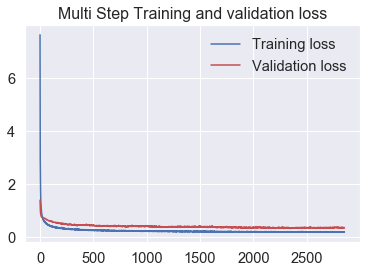

INFO:tensorflow:Assets written to: ./mdl_multi_step_pos_fr_tcn\assets


INFO:tensorflow:Assets written to: ./mdl_multi_step_pos_fr_tcn\assets



 Run #1
Restoring model weights from the end of the best epoch.
Epoch 02837: early stopping
Run #1 : val_loss = 0.2779596149921417


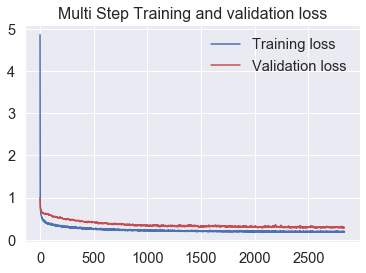

INFO:tensorflow:Assets written to: ./mdl_multi_step_pos_fr_tcn\assets


INFO:tensorflow:Assets written to: ./mdl_multi_step_pos_fr_tcn\assets



 Run #2
Restoring model weights from the end of the best epoch.
Epoch 03657: early stopping
Run #2 : val_loss = 0.29364240169525146
 
Final val_loss = 0.2779596149921417
Mean asbolute Error in people : 3874.0670878411247
 
Wall time: 25min 49s


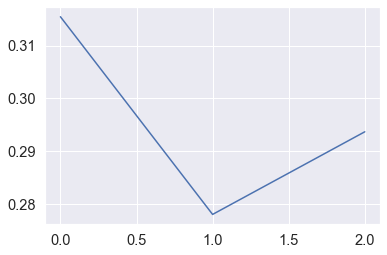

In [154]:
%%time

if mode_train:
    '''
    Run train (Batch Gradient Descent), NB_TRY times, over EPOCHS epochs 
    '''
    # Hyper-parameters
    NB_TRY = 3 #700
    EVALUATION_INTERVAL = 1
    EPOCHS = 5000
    patience = 500
    STEPS_PER_EPOCH = math.ceil(BUFFER_SIZE / BATCH_SIZE)

    
    optim = tf.optimizers.Adam()
    
    batch_size, timesteps, input_dim = \
        None, x_train_multi.shape[1], x_train_multi.shape[2]

    list_loss_multi = []

    for I in range(NB_TRY):
        print("")
        print(f" Run #{I}")

        tf.keras.backend.clear_session()
        # optimizer def 
        #sgd_2 = tf.keras.optimizers.SGD(lr=lr, decay=decay, momentum=momentum, 
        #                      nesterov=nesterov)

        es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', 
                                       verbose=1, patience=patience,
                                       restore_best_weights=True)
        # create model
        
        in_tcn = Input(batch_shape=(batch_size, timesteps, input_dim))

        out_tcn = TCN(nb_filters=64, 
                      kernel_size=2,
                      use_skip_connections=True,
                      return_sequences=False,
                      dilations = [1, 2, 4], 
                      dropout_rate=0.5)(in_tcn)  # The TCN layers are here.
        out_tcn = Dropout(0.1)(out_tcn)
        out_tcn = Dense(int(FUTURE_TARGET/STEP))(out_tcn)
        multi_step_model = Model(inputs=[in_tcn], outputs=[out_tcn])
        
        # compile
        multi_step_model.compile(optimizer=optim, loss='mae')
        # fitting
        multi_step_history = multi_step_model.fit(train_data_multi, 
                                                epochs=EPOCHS,
                                                steps_per_epoch=STEPS_PER_EPOCH,
                                                validation_data=val_data_multi,
                                                validation_steps=1,
                                                callbacks=[es],
                                                verbose=0)
        # eval
        mae_curr = np.min(multi_step_history.history['val_loss'])

        if (I == 0):
            list_loss_multi.append(mae_curr)

        # find the best model
        print(f"Run #{I} : val_loss = {mae_curr}")
        if (mae_curr < np.min(list_loss_multi)) | (I == 0):
            # plot history
            plot_train_history(multi_step_history,
                       'Multi Step Training and validation loss')
            # save
            if not(os.path.isdir(PATH_MDL_MULTI_STEP)):
                os.mkdir(PATH_MDL_MULTI_STEP)
            multi_step_model.save(PATH_MDL_MULTI_STEP)

        if (I != 0):   
            list_loss_multi.append(mae_curr)

    print(" ")
    print(f"Final val_loss = {np.min(list_loss_multi)}")
    print("Mean asbolute Error in people :",
          data_std[4] * np.min(list_loss_multi))
    print(" ")
    plt.plot(list_loss_multi)


In [155]:
# new ref : 24/06/2021
#Train Mean Error  [nb of cases]:  4691.218482315059
#Val. Mean Error  [nb of cases]:  5361.96017213067
#Val. Mean nb cases  [nb of cases]:  17086.04452690167
#Val. Mean Relative Error [%]:  31.382103468642846
# version No skip connexion / internal dropout 0.05 /  dropout on last layer 0.4
#Train Mean Error  [nb of cases]:  4434.365795614253
#Val. Mean Error  [nb of cases]:  5650.963417076767
#Val. Mean nb cases  [nb of cases]:  17086.04452690167
#Val. Mean Relative Error [%]:  33.07356133936925

y_train_multi_pred = multi_step_model.predict(x_train_multi)
mean_error_train = data_std[4] * mean_absolute_error(y_train_multi, 
                                                   y_train_multi_pred)
print("Train Mean Error  [nb of cases]: ", mean_error_train)
y_val_multi_pred = multi_step_model.predict(x_val_multi)
mean_error_val = data_std[4] * mean_absolute_error(y_val_multi, 
                                                   y_val_multi_pred)

print("Val. Mean Error  [nb of cases]: ", mean_error_val)
mean_val = np.mean(data_std[4] * y_val_multi + data_mean[4])
print("Val. Mean nb cases  [nb of cases]: ", mean_val)
print("Val. Mean Relative Error [%]: ", 100*mean_error_val/mean_val)

Train Mean Error  [nb of cases]:  1625.2761771684186
Val. Mean Error  [nb of cases]:  4092.6464821602094
Val. Mean nb cases  [nb of cases]:  17086.04452690167
Val. Mean Relative Error [%]:  23.953153555911733


### Eval

In [156]:
PATH_MDL_MULTI_STEP

'./mdl_multi_step_pos_fr_tcn'

In [157]:
%%time
# reload best model
multi_step_model = tf.keras.models.load_model(PATH_MDL_MULTI_STEP)

Wall time: 1.27 s


In [158]:
# online version before 24/06/2021: 
#Train Mean Error  [nb of cases]:  4796.392175023473
#Val. Mean Error  [nb of cases]:  5321.471272441916
#Val. Mean nb cases  [nb of cases]:  17086.04452690167
#Val. Mean Relative Error [%]:  31.14513288352582
# new 24/06/2021
#Train Mean Error  [nb of cases]:  4691.218482315059
#Val. Mean Error  [nb of cases]:  5361.96017213067
#Val. Mean nb cases  [nb of cases]:  17086.04452690167
#Val. Mean Relative Error [%]:  31.382103468642846

y_train_multi_pred = multi_step_model.predict(x_train_multi)
mean_error_train = data_std[4] * mean_absolute_error(y_train_multi, 
                                                   y_train_multi_pred)
print("Train Mean Error  [nb of cases]: ", mean_error_train)
y_val_multi_pred = multi_step_model.predict(x_val_multi)
mean_error_val = data_std[4] * mean_absolute_error(y_val_multi, 
                                                   y_val_multi_pred)

print("Val. Mean Error  [nb of cases]: ", mean_error_val)
mean_val = np.mean(data_std[4] * y_val_multi + data_mean[4])
print("Val. Mean nb cases  [nb of cases]: ", mean_val)
print("Val. Mean Relative Error [%]: ", 100*mean_error_val/mean_val)

Train Mean Error  [nb of cases]:  1914.6777860670807
Val. Mean Error  [nb of cases]:  3874.066797391144
Val. Mean nb cases  [nb of cases]:  17086.04452690167
Val. Mean Relative Error [%]:  22.673865746349282


In [159]:
multi_step_model.predict(x_val_multi)

array([[ 4.48909760e-01, -5.32612622e-01,  2.40664625e+00,
         1.70655823e+00,  1.55451477e+00,  1.70981872e+00,
         1.74891853e+00],
       [-4.70197856e-01,  2.23057938e+00,  1.90161753e+00,
         1.70622301e+00,  1.79206669e+00,  2.02262545e+00,
         7.39532351e-01],
       [ 2.11468601e+00,  1.76557171e+00,  1.48947024e+00,
         1.59112787e+00,  1.73492348e+00,  6.56815648e-01,
        -4.94980514e-01],
       [ 1.92962325e+00,  1.72341239e+00,  1.77414012e+00,
         1.90831232e+00,  8.05952549e-01, -2.08351523e-01,
         2.59682608e+00],
       [ 1.93862927e+00,  1.99752772e+00,  2.08179140e+00,
         5.85853815e-01, -6.05388105e-01,  2.97540522e+00,
         2.11630535e+00],
       [ 1.74193609e+00,  1.93909276e+00,  5.35910845e-01,
        -6.06638908e-01,  2.76156902e+00,  2.14978313e+00,
         1.81103420e+00],
       [ 1.50524795e+00,  5.08691192e-01, -6.30674481e-01,
         1.95878434e+00,  1.81763375e+00,  1.52844822e+00,
         1.4906601

In [160]:
y_val_multi_pred.shape[0]

77

In [161]:
val_data_multi

<RepeatDataset shapes: ((None, 14, 9), (None, 7)), types: (tf.float64, tf.float64)>

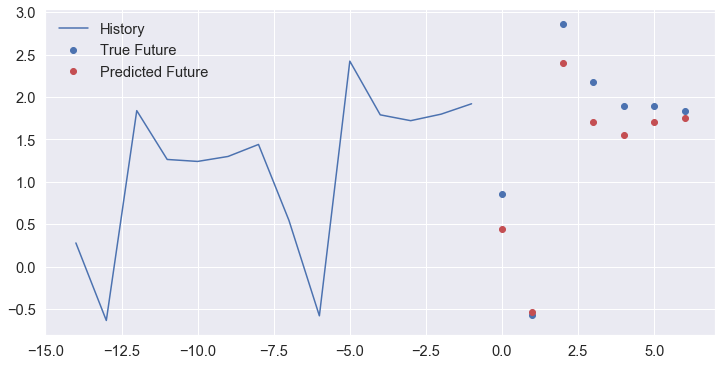

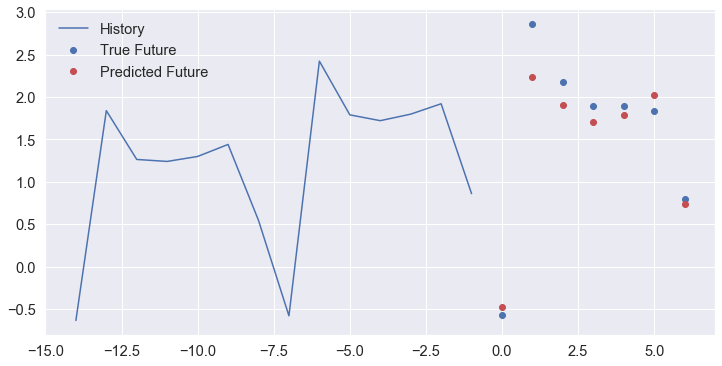

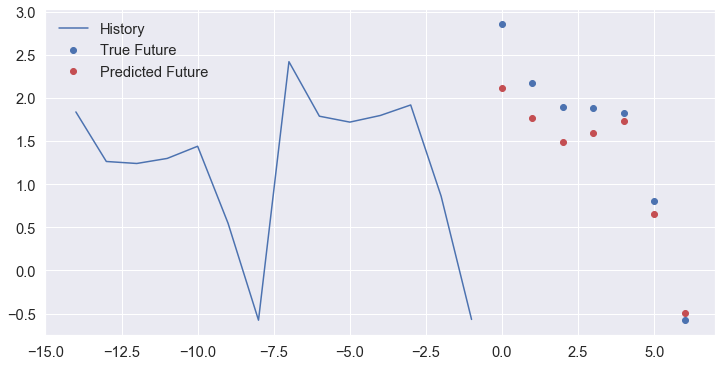

In [162]:
for x, y in val_data_multi.take(1):
    for I in range(3):
        multi_step_plot(x[I], y[I], multi_step_model.predict(x)[I])

### Final Future Prediction

In [163]:
nb_period_plot = 23
NB_DAY_PLOT = FUTURE_TARGET*nb_period_plot

In [164]:
PATH_MDL_MULTI_STEP

'./mdl_multi_step_pos_fr_tcn'

In [165]:
# reload best model
multi_step_model = tf.keras.models.load_model(PATH_MDL_MULTI_STEP)

In [166]:
TRAIN_SPLIT

318

In [167]:
# reload data
df_feat_fr = pd.read_csv(PATH_DF_FEAT_FR)
df_feat_fr.index = df_feat_fr["date"]
# prepare features
features = df_feat_fr.copy().filter(items=['T_min', 'T_max', 'H_min',
                                           'H_max', 'pos', 'test', 'day_num',
                                          'age_pos', 'age_test'])
# calculate mean & std 
#TRAIN_SPLIT = 93
# prepare dataset
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)

dataset = (dataset-data_mean)/data_std

In [168]:
df_feat_fr.shape

(402, 15)

In [169]:
%%time
# prepare data : very last days
x_multi = np.array([dataset[-PAST_HISTORY:,:]]) 
# predict next days
y_multi_pred = multi_step_model.predict(x_multi)
y_multi_pred

# convert in positive cases
y_pos_pred = y_multi_pred * data_std[4] + data_mean[4]


Wall time: 124 ms


In [170]:
df_feat_fr.date.min()

'2020-05-13'

In [171]:
df_feat_fr.date.max()

'2021-06-18'

In [172]:
df_feat_fr.pos.std()

14015.001153888004

In [173]:
data_std[4]

13937.517822330592

In [174]:
str_date_0 = add_days(df_feat_fr.date.max(), -NB_DAY_PLOT)
str_date_0

'2021-01-08'

In [175]:
# last nth days
df_plot = df_feat_fr[df_feat_fr["date"] >= str_date_0].copy()

# add pos pred next days from last day : date, pos, total (sum)
str_date_pred_0 = df_feat_fr.date.max()
str_date_pred_1 = add_days(str_date_pred_0, FUTURE_TARGET)
list_dates_pred = generate_list_dates(str_date_pred_0, str_date_pred_1)
# figure 
df_plot_pred = pd.DataFrame(index=list_dates_pred, columns=["date"], 
                       data=list_dates_pred)

df_plot_pred["pos"] = y_pos_pred[0].astype(int)
arr_nb_pred = df_plot_pred["pos"].cumsum().values
df_plot_pred["nb_cases"] = df_plot["nb_cases"].max() + arr_nb_pred
    
df_plot_pred

date   pos  nb_cases
2021-06-19  2021-06-19  2858   5693545
2021-06-20  2021-06-20  1929   5695474
2021-06-21  2021-06-21  5401   5700875
2021-06-22  2021-06-22  4869   5705744
2021-06-23  2021-06-23  5099   5710843
2021-06-24  2021-06-24  5320   5716163
2021-06-25  2021-06-25  5289   5721452

In [176]:
df_feat_fr.iloc[TRAIN_SPLIT]["date"]

'2021-03-27'

In [177]:
df_plot

T_min        date       T_max      H_min      H_max  extrap  \
date                                                                           
2021-01-08  277.958333  2021-01-08  283.545000  67.750000  89.866667     0.0   
2021-01-09  278.260000  2021-01-09  282.935000  69.483333  89.550000     0.0   
2021-01-10  278.626667  2021-01-10  283.198333  68.533333  87.433333     0.0   
2021-01-11  277.968333  2021-01-11  283.548333  68.450000  88.216667     0.0   
2021-01-12  279.793333  2021-01-12  285.981667  72.283333  90.016667     0.0   
...                ...         ...         ...        ...        ...     ...   
2021-06-14  289.731667  2021-06-14  299.831667  49.766667  83.683333     0.0   
2021-06-15  290.350000  2021-06-15  299.773333  51.966667  84.866667     0.0   
2021-06-16  290.698333  2021-06-16  300.330000  54.766667  87.483333     0.0   
2021-06-17  291.226667  2021-06-17  297.420000  64.366667  89.683333     0.0   
2021-06-18  290.821667  2021-06-18  298.035000  60.700000  88.983333     0.0   

              pos    age_pos    test   age_test  day_num  nb_cases  sum_cases  \
date                                                                            
2021-01-08  19317  47.622716  347941  49.297033        5   2711706   212528.0   
2021-01-09  10869  47.053455  187560  48.403162        6   2722575   213705.0   
2021-01-10   2555  52.648532   41669  51.191269        0   2725130   214183.0   
2021-01-11  25909  49.770041  393755  51.008411        1   2751039   218111.0   
2021-01-12  20240  49.949012  335378  50.410766        2   2771279   218910.0   
...           ...        ...     ...        ...      ...       ...        ...   
2021-06-14   3920  39.861990  337285  43.112054        1   5680443    64639.0   
2021-06-15   2813  39.135087  280727  40.932269        2   5683256    59526.0   
2021-06-16   2492  39.583467  247709  44.233136        3   5685748    54461.0   
2021-06-17   2455  39.395519  314162  39.614202        4   5688203    49936.0   
2021-06-18   2484  39.342995  378648  41.117230        5   5690687    45830.0   

                  Rt  rate_pos  
date                            
2021-01-08  1.191354  5.551803  
2021-01-09  1.185452  5.794946  
2021-01-10  1.187761  6.131657  
2021-01-11  1.193657  6.579980  
2021-01-12  1.174971  6.034981  
...              ...       ...  
2021-06-14  0.473144  1.162222  
2021-06-15  0.461099  1.002041  
2021-06-16  0.442675  1.006019  
2021-06-17  0.425060  0.781444  
2021-06-18  0.410678  0.656018  

[162 rows x 15 columns]

### Figure

In [178]:
# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Create and style traces
# total
fig.add_trace(go.Scatter(x=df_plot["date"].astype(np.datetime64), 
                         y=df_plot["nb_cases"],
                    mode='lines+markers',
                    line_shape='linear',
                    connectgaps=True, name="Total cases"),
             secondary_y=False)

fig.add_trace(go.Scatter(x=df_plot_pred["date"].astype(np.datetime64), 
                         y=df_plot_pred["nb_cases"],
                    mode='lines+markers',
                    line_shape='linear',
                    connectgaps=True, name="Total predicted"),
             secondary_y=False)
# new cases
fig.add_trace(go.Bar(x=df_plot["date"].astype(np.datetime64), 
                     y=df_plot["pos"], 
                     name="New cases"), 
             secondary_y=True)

fig.add_trace(go.Bar(x=df_plot_pred["date"].astype(np.datetime64), 
            y=df_plot_pred["pos"], 
            name="New predicted"), 
            secondary_y=True)
# Edit the layout
title_fig = '<b>COVID-19 Confirmed cases in France with prediction</b><br>' + \
    'LMST Deep Learning Model : ' + \
    'prediction of <b>{} days</b>'.format(FUTURE_TARGET) + \
    ' from <b>last {} days</b>'.format(PAST_HISTORY) + \
    '<br>Trained until ' + df_feat_fr.iloc[TRAIN_SPLIT]["date"]

fig.update_layout(title=title_fig,
                   yaxis_title='nb confirmed cases')
fig.update_layout(legend_orientation="h", legend=dict(x=0, y=1))

fig.update_yaxes(title_text="daily cases", secondary_y=True)

fig.show()


### Predict all past

In [179]:
nb_period_plot

23

In [180]:
dataset.shape

(402, 9)

In [181]:
%%time
# prepare list of past histories
list_x = create_list_past_hist(dataset, nb_period_plot=nb_period_plot)
# predict
y_multi_pred = predict_list(list_x, multi_step_model)
# convert in positive cases
y_pos_pred = (y_multi_pred * data_std[4]) + data_mean[4] 
y_pos_pred

[227 - 241]
[234 - 248]
[241 - 255]
[248 - 262]
[255 - 269]
[262 - 276]
[269 - 283]
[276 - 290]
[283 - 297]
[290 - 304]
[297 - 311]
[304 - 318]
[311 - 325]
[318 - 332]
[325 - 339]
[332 - 346]
[339 - 353]
[346 - 360]
[353 - 367]
[360 - 374]
[367 - 381]
[374 - 388]
[381 - 395]
23
Wall time: 844 ms


array([[ 9105.619 ,  1151.3262, 24363.715 , 18671.527 , 17461.785 ,
        18102.652 , 18545.836 ,  9985.287 ,  2030.96  , 25871.629 ,
        19843.654 , 18606.83  , 19178.25  , 19754.887 , 10351.3125,
         2205.5195, 26754.307 , 20487.557 , 19216.174 , 20222.562 ,
        21014.326 , 10318.304 ,  2099.3818, 26153.914 , 20255.602 ,
        18834.137 , 19770.383 , 20765.115 ,  9836.304 ,  2670.3008,
        23115.809 , 18200.254 , 16992.43  , 17215.098 , 18124.69  ,
         9588.953 ,  2397.374 , 23818.59  , 18938.71  , 17740.322 ,
        18248.127 , 19189.729 , 10075.612 ,  2527.622 , 24939.87  ,
        19391.887 , 18223.469 , 19258.21  , 20009.537 , 10260.005 ,
         2818.0195, 24521.166 , 19444.59  , 18080.832 , 18915.72  ,
        20178.688 , 11518.877 ,  2695.376 , 28308.23  , 22395.674 ,
        21023.469 , 21996.508 , 23435.488 , 13631.453 ,  3114.2822,
        34359.1   , 27697.453 , 25590.182 , 27433.887 , 28486.266 ,
        17537.842 ,  3943.3887, 43967.08  , 3471

In [182]:
y_pos_pred.shape

(1, 161)

In [183]:
# create df out prediction
K_days = y_pos_pred.shape[1]
str_date_pred_1 = df_feat_fr.date.max()
str_date_pred_0 = add_days(str_date_pred_1, -1*K_days)
list_dates_pred = generate_list_dates(str_date_pred_0, str_date_pred_1)
print(len(list_dates_pred))
print(str_date_pred_0)
print(str_date_pred_1)

df_plot_pred_all = pd.DataFrame(index=list_dates_pred, columns=["date"], 
                       data=list_dates_pred)

df_plot_pred_all["pos"] = y_pos_pred[0].astype(int)

list_nb_cases =[]
str_date_nb_0 = str_date_pred_0
for I in range(0, df_plot_pred_all["pos"].shape[0], FUTURE_TARGET):
    str_date_nb_0 = add_days(str_date_pred_0, I)
    nb_0 = df_feat_fr[df_feat_fr["date"] == str_date_nb_0]["nb_cases"][0]
    arr_nb = nb_0 + \
        df_plot_pred_all.iloc[I:I+FUTURE_TARGET]["pos"].cumsum().values
    list_nb_cases = list_nb_cases + arr_nb.tolist()
df_plot_pred_all["nb_cases"] = list_nb_cases


df_plot_pred_all

161
2021-01-08
2021-06-18


date    pos  nb_cases
2021-01-09  2021-01-09   9105   2720811
2021-01-10  2021-01-10   1151   2721962
2021-01-11  2021-01-11  24363   2746325
2021-01-12  2021-01-12  18671   2764996
2021-01-13  2021-01-13  17461   2782457
...                ...    ...       ...
2021-06-14  2021-06-14   7379   5686031
2021-06-15  2021-06-15   6559   5692590
2021-06-16  2021-06-16   6148   5698738
2021-06-17  2021-06-17   6661   5705399
2021-06-18  2021-06-18   6893   5712292

[161 rows x 3 columns]

### Figure all past 

In [184]:
str_date_mdl =  df_feat_fr.iloc[TRAIN_SPLIT]["date"]

In [185]:
# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])
# Create and style traces
# total
fig.add_trace(go.Scatter(x=df_plot["date"].astype(np.datetime64), 
                         y=df_plot["nb_cases"],
                    mode='lines+markers',
                    line_shape='linear',
                    line_color="blue",
                    connectgaps=True, name="Total"),
             secondary_y=False)
fig.add_trace(go.Scatter(x=df_plot_pred_all["date"].astype(np.datetime64), 
                         y=df_plot_pred_all["nb_cases"],
                    mode='lines+markers',
                    line_shape='hv',
                    line_color="red",
                    connectgaps=True, name="Total (estim.)"),
             secondary_y=False)
fig.add_trace(go.Scatter(x=df_plot_pred["date"].astype(np.datetime64), 
                         y=df_plot_pred["nb_cases"],
                    mode='lines+markers',
                    line_shape='hv',
                    line_color="orange",
                    connectgaps=True, name="Total (future estim.)"),
             secondary_y=False)
# new cases
fig.add_trace(go.Bar(x=df_plot["date"].astype(np.datetime64), 
                     y=df_plot["pos"], 
                     name="Daily", opacity=0.33, marker_color="blue"), 
             secondary_y=True)
fig.add_trace(go.Bar(x=df_plot_pred["date"].astype(np.datetime64), 
            y=df_plot_pred["pos"], 
            name="Daily (future estim.)", opacity=0.33, marker_color="orange"), 
            secondary_y=True)
fig.add_trace(go.Scatter(x=df_plot_pred_all["date"].astype(np.datetime64), 
                         y=df_plot_pred_all["pos"],
                    mode='lines+markers',
                    marker_symbol="cross",
                    line_color="red", opacity=0.33,    
                    connectgaps=True, name="Daily (estim.)"),
             secondary_y=True)
# Edit the layout
title_fig = '<b>COVID-19 Confirmed cases in France</b>' + \
    '<br>Model trained until <b>' + str_date_mdl + '</b>' + \
    '<br>predicts next {} days with last {} days until <b>' \
    .format(FUTURE_TARGET, PAST_HISTORY) + \
    df_plot_pred["date"].max() + '</b>'
fig.update_layout(title=title_fig, yaxis_title='nb <b>Total</b> cases')
fig.update_layout(legend_orientation="h", legend=dict(x=0, y=1))
fig.update_layout(height=600)

fig.update_yaxes(title_text="nb <b>Daily</b> cases", 
                secondary_y=True)
    
fig.show()


In [186]:
# Create figure with secondary y-axis
#fig = make_subplots()
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(go.Bar(x=df_plot_pred["date"].astype(np.datetime64), 
            y=df_plot_pred["pos"], 
            name="Daily (future estim.)", opacity=0.5), 
            secondary_y=True)

fig.add_trace(go.Bar(x=df_plot["date"].astype(np.datetime64), 
                     y=df_plot["pos"], 
                     name="Daily", opacity=0.5), 
             secondary_y=True)



fig.add_trace(go.Bar(x=df_plot_pred_all["date"].astype(np.datetime64), 
            y=df_plot_pred_all["pos"], 
            name="Daily (estim.)", opacity=0.5), 
            secondary_y=True)



fig.update_layout(barmode='group')
# Edit the layout
title_fig = '<b>COVID-19 Confirmed cases in France</b>' + \
    '<br>Model trained until <b>' + str_date_mdl + '</b>' + \
    '<br>predicts next {} days with last {} days until <b>' \
    .format(FUTURE_TARGET, PAST_HISTORY) + \
    df_plot_pred["date"].max() + '</b>'
fig.update_layout(title=title_fig, yaxis_title='nb <b>Total</b> cases')
fig.update_layout(legend_orientation="h", legend=dict(x=0, y=1))
fig.update_layout(height=600)

fig.update_yaxes(title_text="nb <b>Daily</b> cases", 
                secondary_y=True)
    
fig.show()

### Features Importance

#### for all seq

In [187]:
arr_grads = grads_by_features(x_train_multi, multi_step_model)


In [188]:
df_grads = pd.DataFrame(data=arr_grads, columns=list_feat)
df_grads

T_min     T_max     H_min     H_max       pos      test   day_num  \
0   -0.005979 -0.006955 -0.001753  0.000931  0.056678  0.010333 -0.010347   
1   -0.009867 -0.010817 -0.006192  0.010887  0.059351  0.028539  0.008242   
2   -0.008847  0.001900 -0.006598  0.003003  0.051659  0.034589 -0.008925   
3   -0.013568  0.000762 -0.007916  0.003852  0.051194  0.020874 -0.012914   
4   -0.004618 -0.001818 -0.008760  0.004947  0.058446  0.022912 -0.000239   
..        ...       ...       ...       ...       ...       ...       ...   
299  0.042371 -0.114396 -0.049923  0.033677  0.633848 -0.331712 -0.082725   
300  0.025768 -0.078314 -0.028702  0.033966  0.511420 -0.247276  0.008691   
301  0.037152 -0.099559 -0.031724  0.028067  0.513891 -0.238918 -0.032052   
302  0.033437 -0.119187 -0.026016 -0.001779  0.456244 -0.137642 -0.080907   
303  0.039958 -0.121375 -0.024441 -0.003032  0.463165 -0.212217 -0.083319   

      age_pos  age_test  
0    0.001940 -0.019720  
1    0.003814 -0.013715  
2   -0.004860 -0.002532  
3    0.000056 -0.013496  
4   -0.003634 -0.012558  
..        ...       ...  
299 -0.013285 -0.113714  
300 -0.008359 -0.098558  
301 -0.037824 -0.089434  
302 -0.097927 -0.042502  
303 -0.084479 -0.067360  

[304 rows x 9 columns]

(-0.6, 0.6)

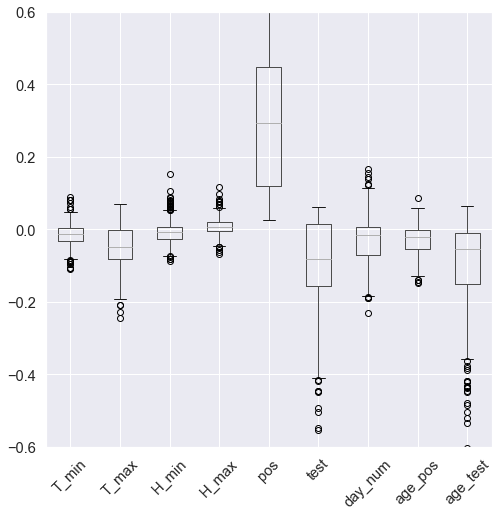

In [189]:
fig = plt.figure(figsize=(8, 8))
boxplot = df_grads.boxplot(rot=45)
ax = fig.gca()
ax.set_ylim([-0.6, 0.6])

#### By days before

In [190]:
sum_grads = grads_by_days(x_train_multi, multi_step_model)

In [191]:
df_time_grads = pd.DataFrame(data=sum_grads, columns=list_feat, 
                             index = [ -I for I in range(14, 0, -1)])
df_time_grads

T_min         T_max         H_min         H_max           pos  \
-14  2.125817e-06 -3.525322e-07  8.049337e-08 -1.190101e-07  3.323389e-07   
-13 -4.801836e-06  3.649914e-06 -2.346602e-08  2.697843e-07  3.809036e-06   
-12 -4.961019e-07  1.461582e-06  1.854459e-06  2.931295e-10  3.022704e-06   
-11 -2.084544e-05  1.674920e-05 -9.714264e-07  8.756390e-06  1.166741e-05   
-10  1.200350e-05 -2.973654e-05  1.191947e-05  4.082623e-06  5.884099e-05   
-9  -2.457967e-04 -1.442649e-04  3.219060e-04 -1.351842e-04  2.297026e-03   
-8   9.042641e-06 -5.135666e-05 -8.012153e-06 -9.495965e-06  5.540494e-05   
-7  -1.467631e-04  3.885920e-04 -1.939948e-06  1.141242e-04 -1.105701e-03   
-6  -4.593654e-05  2.000570e-04  4.747424e-05 -1.444839e-05 -2.765871e-04   
-5  -2.010809e-04 -3.825883e-04  2.255435e-04  6.239691e-04  1.369263e-03   
-4  -1.638979e-04  8.300631e-05  5.308305e-05  6.076142e-05 -9.261219e-06   
-3  -1.180222e-03 -1.002287e-03  3.912012e-04 -3.842032e-04  5.496223e-03   
-2   4.394087e-04 -7.229625e-04 -1.318985e-03  3.484171e-05  1.801976e-04   
-1   3.387423e-03 -3.949626e-03 -8.486949e-04 -4.429991e-04  1.324573e-02   

         test   day_num       age_pos      age_test  
-14  0.000001  0.000003  6.745970e-07  8.472869e-07  
-13  0.000004 -0.000002  2.162175e-06 -7.394268e-06  
-12  0.000003  0.000003  1.436981e-06  9.279599e-07  
-11 -0.000047 -0.000054 -2.159995e-05 -1.337073e-05  
-10  0.000021 -0.000017  2.287128e-05 -6.264692e-06  
-9  -0.001090 -0.000346 -3.697283e-04 -3.958265e-04  
-8  -0.000087 -0.000017 -5.504409e-05 -3.956171e-05  
-7   0.000323 -0.000205  6.359108e-05  1.858941e-04  
-6   0.000171 -0.000107 -7.459446e-05  2.311759e-05  
-5  -0.002136 -0.002089  6.353250e-05 -2.246162e-04  
-4   0.000061 -0.000051  3.958103e-05  1.099095e-05  
-3  -0.001617 -0.000868 -8.463028e-04 -1.045334e-03  
-2  -0.001267 -0.001148 -9.795815e-04 -9.667274e-05  
-1  -0.004113  0.001061 -1.737464e-03 -1.494837e-03

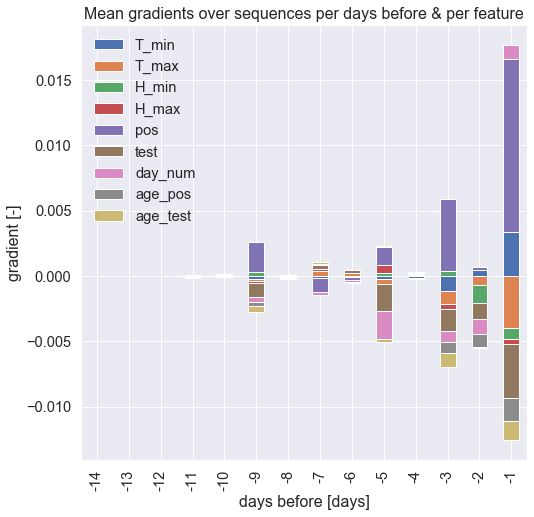

In [192]:
fig, ax = plt.subplots(figsize=(8, 8))
g_bar = df_time_grads.plot(kind='bar', stacked=True, ax=ax,
            title="Mean gradients over sequences per days before & per feature")
plt.xlabel("days before [days]")
plt.ylabel("gradient [-]");

=> Big impact of "pos", "test" and "age_test" but one day before (a little 5 days before) , and a little less 9 and 3 days before.  
But why not have an impact on the even days before?  
  
We can try to change input to see prediction on even days : 

In [193]:
i_seq = 123
x_mod = x_train_multi[i_seq].copy()

x_mod[0] = x_mod[0]*0.5
x_mod[2] = x_mod[2]*0.5
x_mod[4] = x_mod[4]*0.5
x_mod[6] = x_mod[6]*0.5
x_mod[10] = x_mod[10]*0.5
x_mod[12] = x_mod[12]*0.5
x_mod

array([[ 0.35179445,  0.79242455, -0.88222697, -0.20556744, -0.41136987,
        -0.54184206, -0.75444568, -0.31593769, -0.36016679],
       [ 1.1167327 ,  1.97725202, -2.05331138, -1.65134972,  0.10949226,
         0.48371757, -1.00750427, -1.07714007, -1.52619092],
       [ 0.71189649,  0.83617218, -0.78944825, -0.70722738,  0.01273721,
         0.2113698 , -0.25305858, -0.62198147, -0.96604928],
       [ 1.27115806,  1.57987779, -1.30151685, -0.82918483,  0.01801256,
         0.30347587, -0.00473007, -1.29120302, -2.12139064],
       [ 0.62763585,  0.71425405, -0.80753895, -0.56563498,  0.01693452,
         0.13981995,  0.24832852, -0.61895488, -0.91434892],
       [ 1.13777036,  1.3319746 , -1.12361127, -1.68386472,  0.00359105,
         0.28080846,  0.99804413, -1.25297354, -1.56847946],
       [ 0.66892596,  0.5450185 , -0.24234078, -0.05228246, -0.28376465,
        -0.33540146,  0.74971562, -0.51810116, -0.58380932],
       [ 1.21520684,  0.95315997, -0.17860746,  0.60147498, -0

In [194]:
x_train_multi[i_seq]

array([[ 0.7035889 ,  1.58484911, -1.76445394, -0.41113489, -0.82273973,
        -1.08368411, -1.50889137, -0.63187537, -0.72033358],
       [ 1.1167327 ,  1.97725202, -2.05331138, -1.65134972,  0.10949226,
         0.48371757, -1.00750427, -1.07714007, -1.52619092],
       [ 1.42379299,  1.67234435, -1.57889651, -1.41445476,  0.02547443,
         0.4227396 , -0.50611717, -1.24396294, -1.93209855],
       [ 1.27115806,  1.57987779, -1.30151685, -0.82918483,  0.01801256,
         0.30347587, -0.00473007, -1.29120302, -2.12139064],
       [ 1.25527171,  1.4285081 , -1.6150779 , -1.13126996,  0.03386904,
         0.2796399 ,  0.49665703, -1.23790976, -1.82869783],
       [ 1.13777036,  1.3319746 , -1.12361127, -1.68386472,  0.00359105,
         0.28080846,  0.99804413, -1.25297354, -1.56847946],
       [ 1.33785192,  1.09003699, -0.48468157, -0.10456493, -0.5675293 ,
        -0.67080291,  1.49943123, -1.03620233, -1.16761864],
       [ 1.21520684,  0.95315997, -0.17860746,  0.60147498, -0

In [195]:
seq = tf.Variable(x_train_multi[i_seq][np.newaxis,:,:], dtype=tf.float32)
seq_mod = tf.Variable(x_mod[np.newaxis,:,:], dtype=tf.float32)
predictions = multi_step_model(seq)
predictions_mod = multi_step_model(seq_mod)
try:
    np.testing.assert_almost_equal(predictions.numpy(), 
                               predictions_mod.numpy(), decimal=3)
    print("Even days have no impact on prediction !")
except:
    print("It is not same result, it is normal.")

It is not same result, it is normal.


In [196]:
predictions

<tf.Tensor: shape=(1, 7), dtype=float32, numpy=
array([[-0.80871147,  0.03597891, -0.11457574, -0.12623066, -0.09331539,
        -0.06068066, -0.40710872]], dtype=float32)>

In [197]:
predictions_mod

<tf.Tensor: shape=(1, 7), dtype=float32, numpy=
array([[-0.8177682 ,  0.05682486, -0.10307363, -0.12594548, -0.09730348,
        -0.0727779 , -0.42938483]], dtype=float32)>

In [198]:
x_mod[0] = x_mod[0]*2
x_mod

array([[ 0.7035889 ,  1.58484911, -1.76445394, -0.41113489, -0.82273973,
        -1.08368411, -1.50889137, -0.63187537, -0.72033358],
       [ 1.1167327 ,  1.97725202, -2.05331138, -1.65134972,  0.10949226,
         0.48371757, -1.00750427, -1.07714007, -1.52619092],
       [ 0.71189649,  0.83617218, -0.78944825, -0.70722738,  0.01273721,
         0.2113698 , -0.25305858, -0.62198147, -0.96604928],
       [ 1.27115806,  1.57987779, -1.30151685, -0.82918483,  0.01801256,
         0.30347587, -0.00473007, -1.29120302, -2.12139064],
       [ 0.62763585,  0.71425405, -0.80753895, -0.56563498,  0.01693452,
         0.13981995,  0.24832852, -0.61895488, -0.91434892],
       [ 1.13777036,  1.3319746 , -1.12361127, -1.68386472,  0.00359105,
         0.28080846,  0.99804413, -1.25297354, -1.56847946],
       [ 0.66892596,  0.5450185 , -0.24234078, -0.05228246, -0.28376465,
        -0.33540146,  0.74971562, -0.51810116, -0.58380932],
       [ 1.21520684,  0.95315997, -0.17860746,  0.60147498, -0

In [199]:

seq = tf.Variable(x_train_multi[i_seq][np.newaxis,:,:], dtype=tf.float32)

In [200]:
x_train_multi[i_seq]

array([[ 0.7035889 ,  1.58484911, -1.76445394, -0.41113489, -0.82273973,
        -1.08368411, -1.50889137, -0.63187537, -0.72033358],
       [ 1.1167327 ,  1.97725202, -2.05331138, -1.65134972,  0.10949226,
         0.48371757, -1.00750427, -1.07714007, -1.52619092],
       [ 1.42379299,  1.67234435, -1.57889651, -1.41445476,  0.02547443,
         0.4227396 , -0.50611717, -1.24396294, -1.93209855],
       [ 1.27115806,  1.57987779, -1.30151685, -0.82918483,  0.01801256,
         0.30347587, -0.00473007, -1.29120302, -2.12139064],
       [ 1.25527171,  1.4285081 , -1.6150779 , -1.13126996,  0.03386904,
         0.2796399 ,  0.49665703, -1.23790976, -1.82869783],
       [ 1.13777036,  1.3319746 , -1.12361127, -1.68386472,  0.00359105,
         0.28080846,  0.99804413, -1.25297354, -1.56847946],
       [ 1.33785192,  1.09003699, -0.48468157, -0.10456493, -0.5675293 ,
        -0.67080291,  1.49943123, -1.03620233, -1.16761864],
       [ 1.21520684,  0.95315997, -0.17860746,  0.60147498, -0

In [201]:
x = tf.constant([3.0, 2.0])
with tf.GradientTape() as g:
    g.watch(x)
    y = x * x
dy_dx = g.gradient(y, x)
print(dy_dx)

tf.Tensor([6. 4.], shape=(2,), dtype=float32)


In [202]:
y

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([9., 4.], dtype=float32)>

In [203]:
x

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([3., 2.], dtype=float32)>

In [204]:
#inputs = tf.constant([3.0, 2.0])
inputs = tf.Variable(np.array([1.0, 2.0])[np.newaxis,:], dtype=tf.float32)
a = tf.keras.layers.Dense(3)


In [205]:
with tf.GradientTape() as tape:
    result = a(inputs)
grads = tape.gradient(result, inputs)
grads

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[ 0.28071064, -0.5578031 ]], dtype=float32)>

In [206]:
a.kernel

<tf.Variable 'dense_1/kernel:0' shape=(2, 3) dtype=float32, numpy=
array([[ 0.8855163 , -0.9606995 ,  0.35589385],
       [-0.21635199,  0.42610776, -0.7675589 ]], dtype=float32)>

In [207]:
result

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[ 0.4528123 , -0.10848397, -1.1792239 ]], dtype=float32)>

In [208]:
0.86197734 -0.08069324 + 0.32413316

1.10541726

In [209]:
0.40406668 +  0.89749837 + 0.95976377

2.26132882

In [210]:
0.3729093 + -0.51952934 + -0.27287823

-0.41949826999999995

In [211]:
result[0]

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([ 0.4528123 , -0.10848397, -1.1792239 ], dtype=float32)>

In [212]:
np.array([3.0, 2.0])[np.newaxis,:]

array([[3., 2.]])